# **Analysis and modelling of PIMA diabetes dataset using supervised methods**
## **-by AFZAL**

# About pima diabetes dataset

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

#### Content:
The datasets consists of several medical predictor variables and one target variable, Outcome. Predictor variables includes the number of pregnancies the patient has had, their BMI, insulin level, age, and so on.
The datasets consist of several medical predictor (independent) variables and one target (dependent) variable, Outcome. Independent variables include the number of pregnancies the patient has had, their BMI, insulin level, age, and so on.

### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier

from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.metrics import classification_report, f1_score, confusion_matrix

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

from sklearn.pipeline import Pipeline

import matplotlib.style as style
style.use("seaborn-darkgrid")

import warnings
warnings.filterwarnings('ignore')

### Loading dataset

In [2]:
# importing data
df=pd.read_csv('PIMA_diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### ***Looks like a classification problem***

### Basic info

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


### *seems like no missing values*

In [4]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### *seems like all values are numerical*

### Renaming outcome to target

In [5]:
df.rename(columns={'Outcome':'target'}, inplace=True)

### Data Dictionary

In [6]:
# making description column
description=['Number of times pregnant',
             'Plasma glucose concentration a 2 hours in an oral glucose tolerance test',
             'Diastolic blood pressure (mm Hg)',
             'Triceps skin fold thickness (mm)',
             '2-Hour serum insulin (mu U/ml)',
             'Body mass index (weight in kg/(height in m)^2)',
             'Diabetes pedigree function',
             'Age (years)',
             'Diabetes diagonised (0=No, 1=Yes)',
]

dict1={'Feature':df.columns,
       'Description':description,
}

data_dict=pd.DataFrame(dict1).set_index('Feature')

data_dict

,Description
Feature,
Pregnancies,Number of times pregnant
Glucose,Plasma glucose concentration a 2 hours in an o...
BloodPressure,Diastolic blood pressure (mm Hg)
SkinThickness,Triceps skin fold thickness (mm)
Insulin,2-Hour serum insulin (mu U/ml)
BMI,Body mass index (weight in kg/(height in m)^2)
DiabetesPedigreeFunction,Diabetes pedigree function
Age,Age (years)
target,"Diabetes diagonised (0=No, 1=Yes)"


# EDA

### Getting diabetes rate

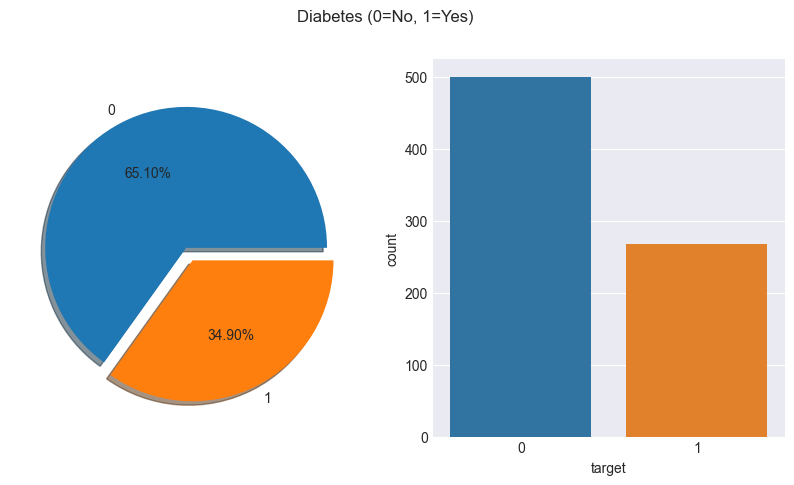

In [7]:
fig,ax=plt.subplots(1,2, figsize=(10,5), dpi=100)

df.target.value_counts().plot.pie(explode=[0,0.1], ax=ax[0], autopct='%1.2f%%', shadow=True)
ax[0].set_ylabel('')

sns.countplot(x='target', data=df, ax=ax[1])

plt.suptitle('Diabetes (0=No, 1=Yes)')
plt.show()

### ***seems like we have an IMBALANCED class problem***

In [8]:
##################################
'''IMPORTING FROM CUSTOM MODULE'''
##################################
from quick_EDA import analysis_quant, analysis_cate, handle_outliers, correlation 

## **UNIVARIATE ANALYSIS**

### analysing numerical features  

In [9]:
#Extracting numerical column names
cols_num=list(df.columns)
cols_num.remove('target')

				ANALYSIS OF: Pregnancies 

5 point summary for: Pregnancies
     Pregnancies
min          0.0
25%          1.0
50%          3.0
75%          6.0
max         17.0
---------------------------------
OUTLIERS in Pregnancies via Z score

Outlier limits:
lower limit: -6.257098753893652 
upper limit: 13.94720292056032

Total outliers: 4
     outliers   Z-score
88         15  3.312645
159        17  3.906578
298        14  3.015679
455        14  3.015679
---------------------------------
OUTLIERS in Pregnancies via IQR

Outlier limits:
lower limit: -6.5 
upper limit: 13.5

Total outliers: 4
88     15
159    17
298    14
455    14
Name: Pregnancies, dtype: int64
---------------------------------


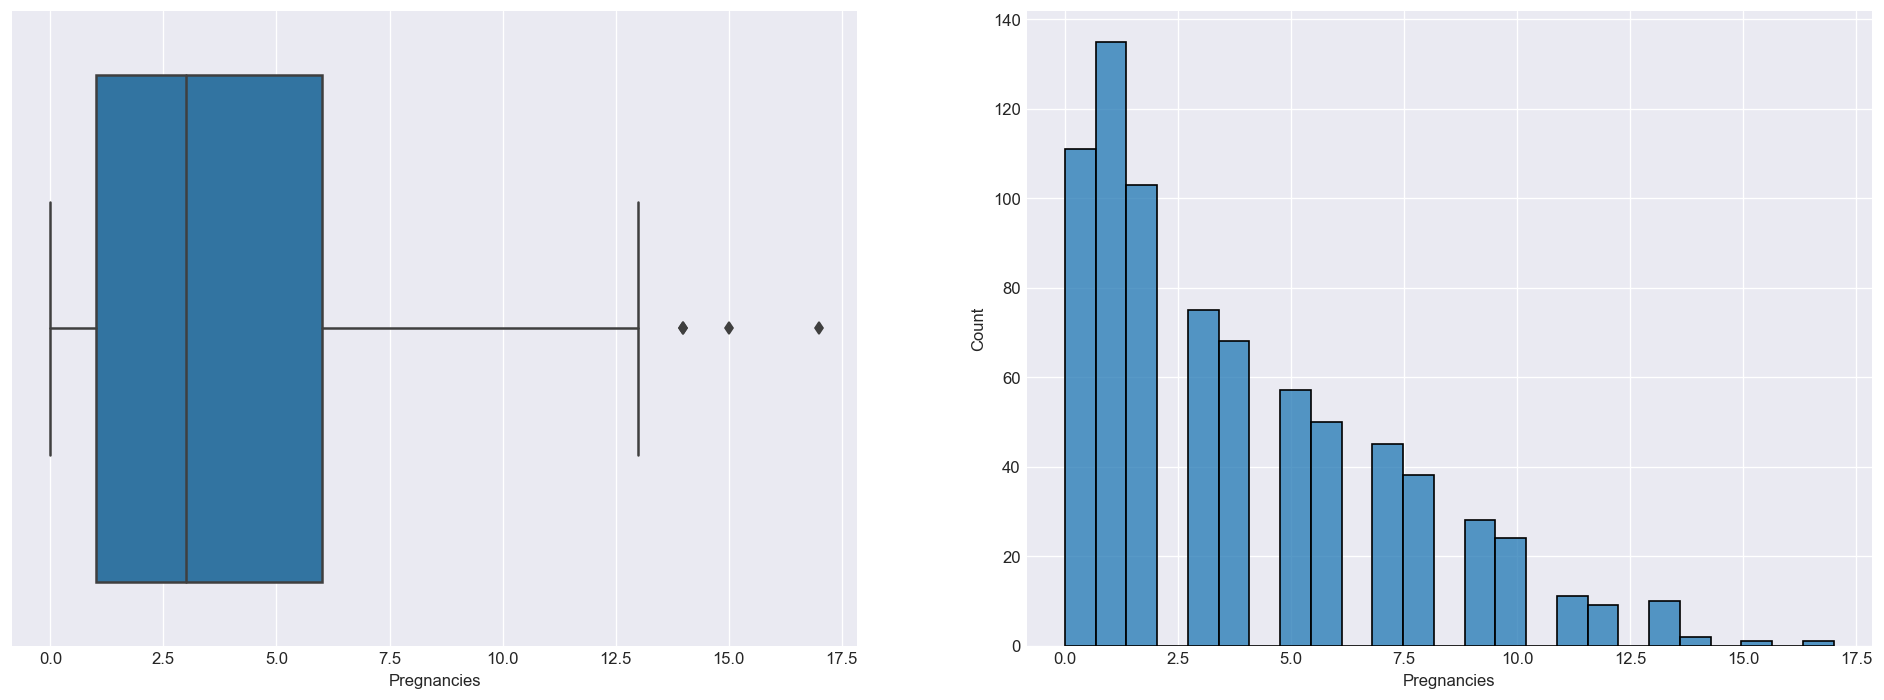

___________________________________________________________________________________________________________
				ANALYSIS OF: Glucose 

5 point summary for: Glucose
     Glucose
min     0.00
25%    99.00
50%   117.00
75%   140.25
max   199.00
---------------------------------
OUTLIERS in Glucose via Z score

Outlier limits:
lower limit: 25.039143525391836 
upper limit: 216.74991897460816

Total outliers: 5
     outliers   Z-score
75          0 -3.783654
182         0 -3.783654
342         0 -3.783654
349         0 -3.783654
502         0 -3.783654
---------------------------------
OUTLIERS in Glucose via IQR

Outlier limits:
lower limit: 37.125 
upper limit: 202.125

Total outliers: 5
75     0
182    0
342    0
349    0
502    0
Name: Glucose, dtype: int64
---------------------------------


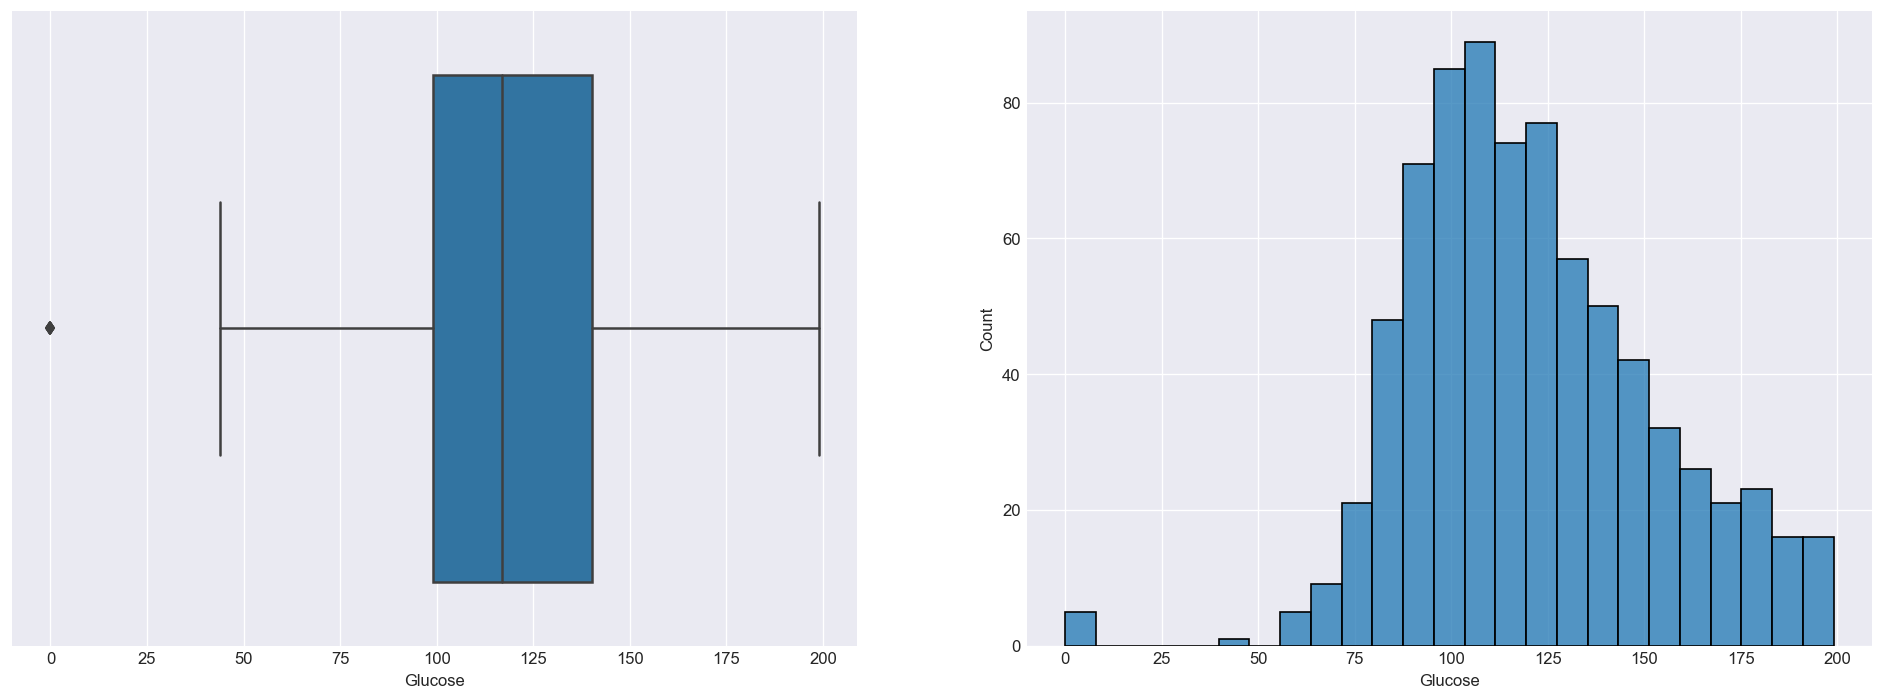

___________________________________________________________________________________________________________
				ANALYSIS OF: BloodPressure 

5 point summary for: BloodPressure
     BloodPressure
min            0.0
25%           62.0
50%           72.0
75%           80.0
max          122.0
---------------------------------
OUTLIERS in BloodPressure via Z score

Outlier limits:
lower limit: 11.075863863054913 
upper limit: 127.1350736369451

Total outliers: 35
     outliers   Z-score
7           0 -3.572597
15          0 -3.572597
49          0 -3.572597
60          0 -3.572597
78          0 -3.572597
81          0 -3.572597
172         0 -3.572597
193         0 -3.572597
222         0 -3.572597
261         0 -3.572597
266         0 -3.572597
269         0 -3.572597
300         0 -3.572597
332         0 -3.572597
336         0 -3.572597
347         0 -3.572597
357         0 -3.572597
426         0 -3.572597
430         0 -3.572597
435         0 -3.572597
453         0 -3.572597
468      

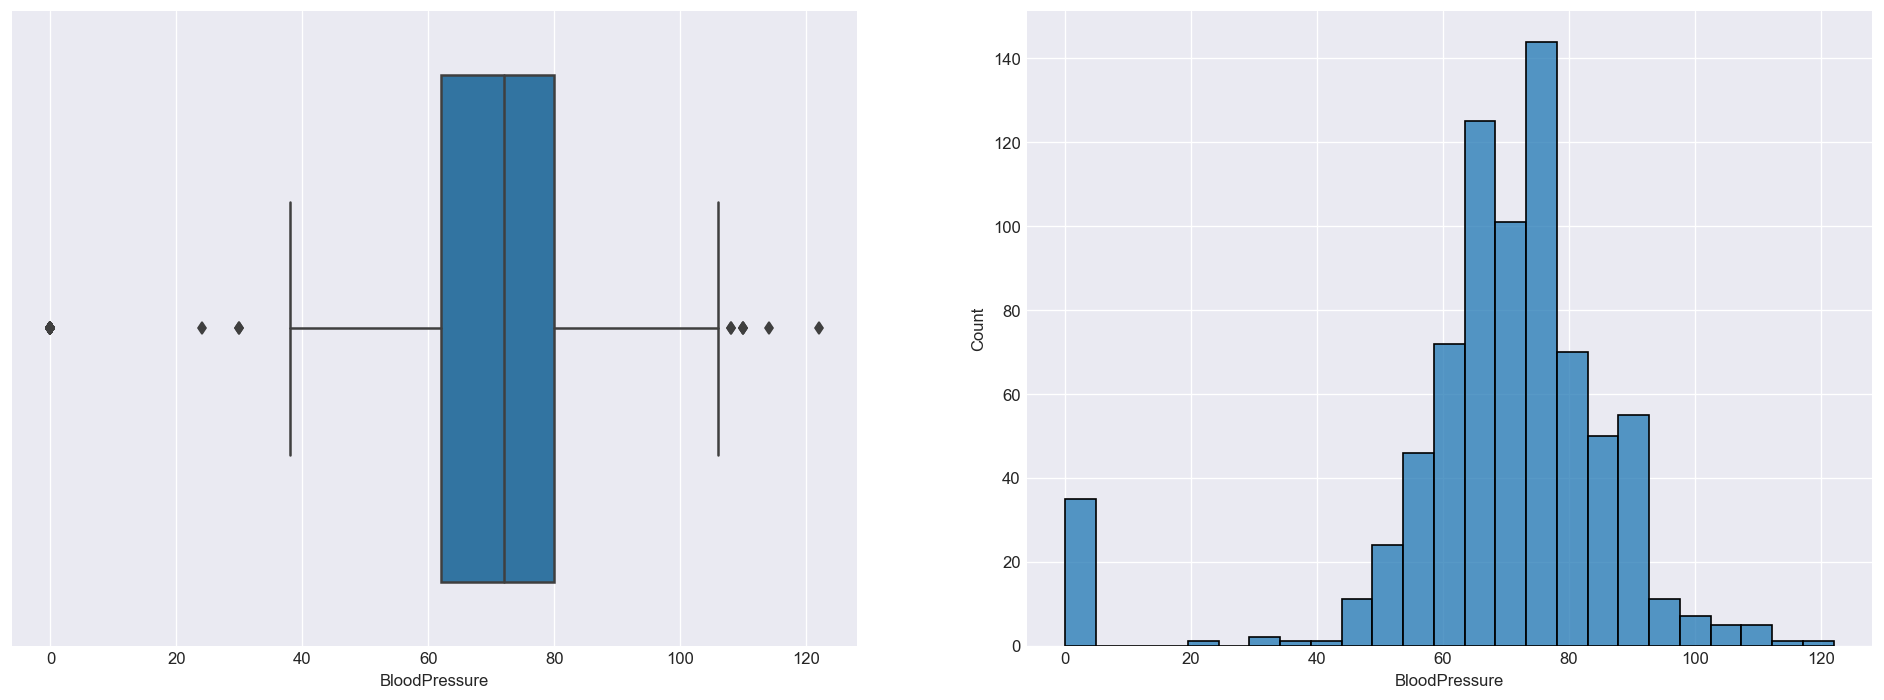

___________________________________________________________________________________________________________
				ANALYSIS OF: SkinThickness 

5 point summary for: SkinThickness
     SkinThickness
min            0.0
25%            0.0
50%           23.0
75%           32.0
max           99.0
---------------------------------
OUTLIERS in SkinThickness via Z score

Outlier limits:
lower limit: -27.28902754615748 
upper limit: 68.36194421282414

Total outliers: 1
     outliers   Z-score
579        99  4.921866
---------------------------------
OUTLIERS in SkinThickness via IQR

Outlier limits:
lower limit: -48.0 
upper limit: 80.0

Total outliers: 1
579    99
Name: SkinThickness, dtype: int64
---------------------------------


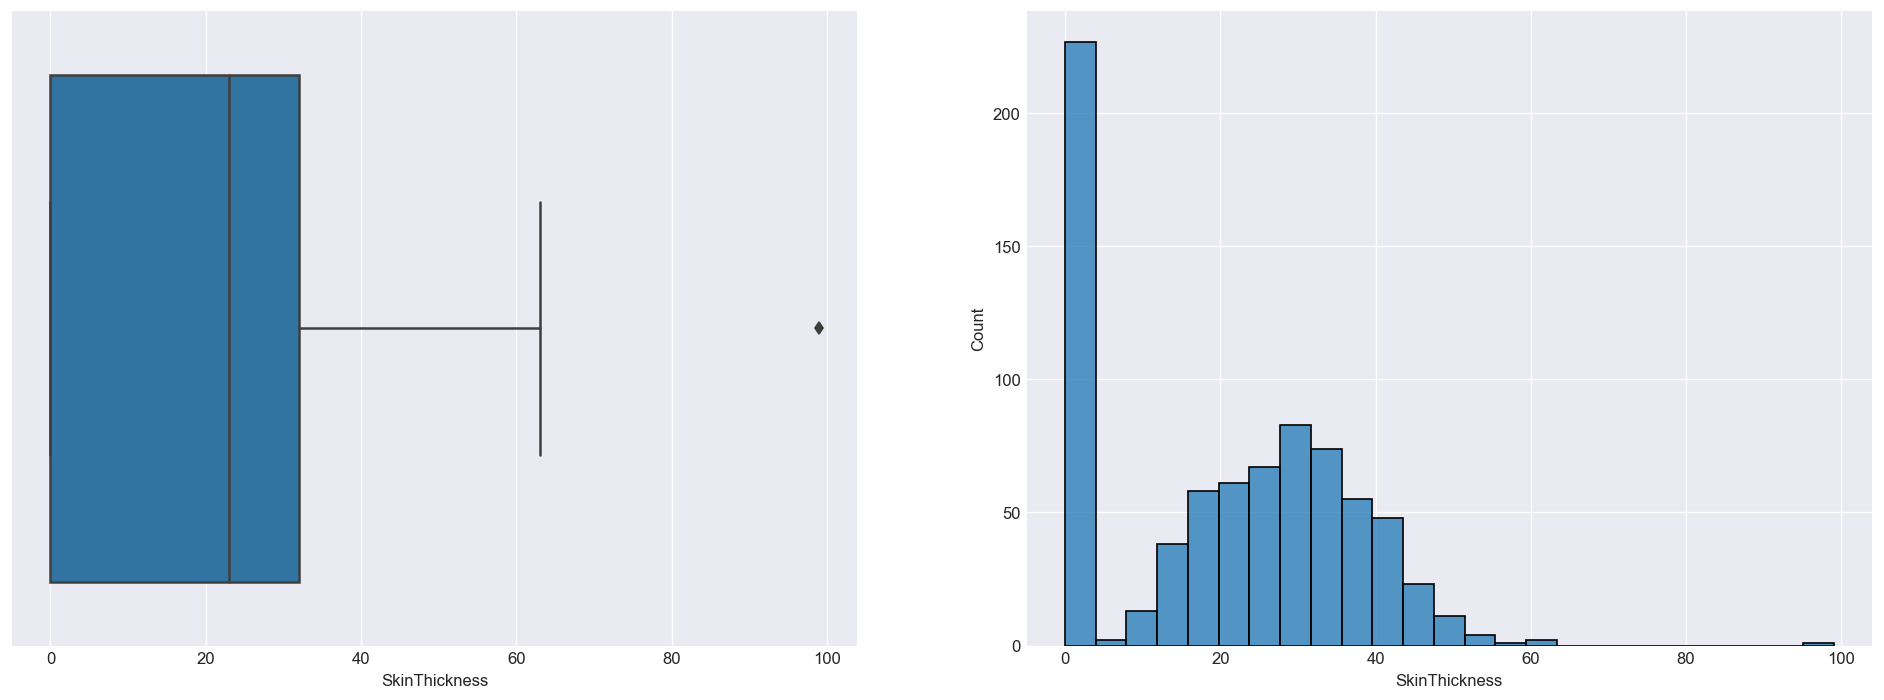

___________________________________________________________________________________________________________
				ANALYSIS OF: Insulin 

5 point summary for: Insulin
     Insulin
min     0.00
25%     0.00
50%    30.50
75%   127.25
max   846.00
---------------------------------
OUTLIERS in Insulin via Z score

Outlier limits:
lower limit: -265.7073686273512 
upper limit: 425.30632696068454

Total outliers: 18
     outliers   Z-score
8         543  4.021922
13        846  6.652839
111       495  3.605143
153       485  3.518314
186       495  3.605143
220       478  3.457534
228       744  5.767184
247       680  5.211479
286       545  4.039288
370       465  3.344656
409       579  4.334506
415       474  3.422802
486       480  3.474899
584       600  4.516847
645       440  3.127584
655       540  3.995873
695       480  3.474899
753       510  3.735386
---------------------------------
OUTLIERS in Insulin via IQR

Outlier limits:
lower limit: -190.875 
upper limit: 318.125

Total outl

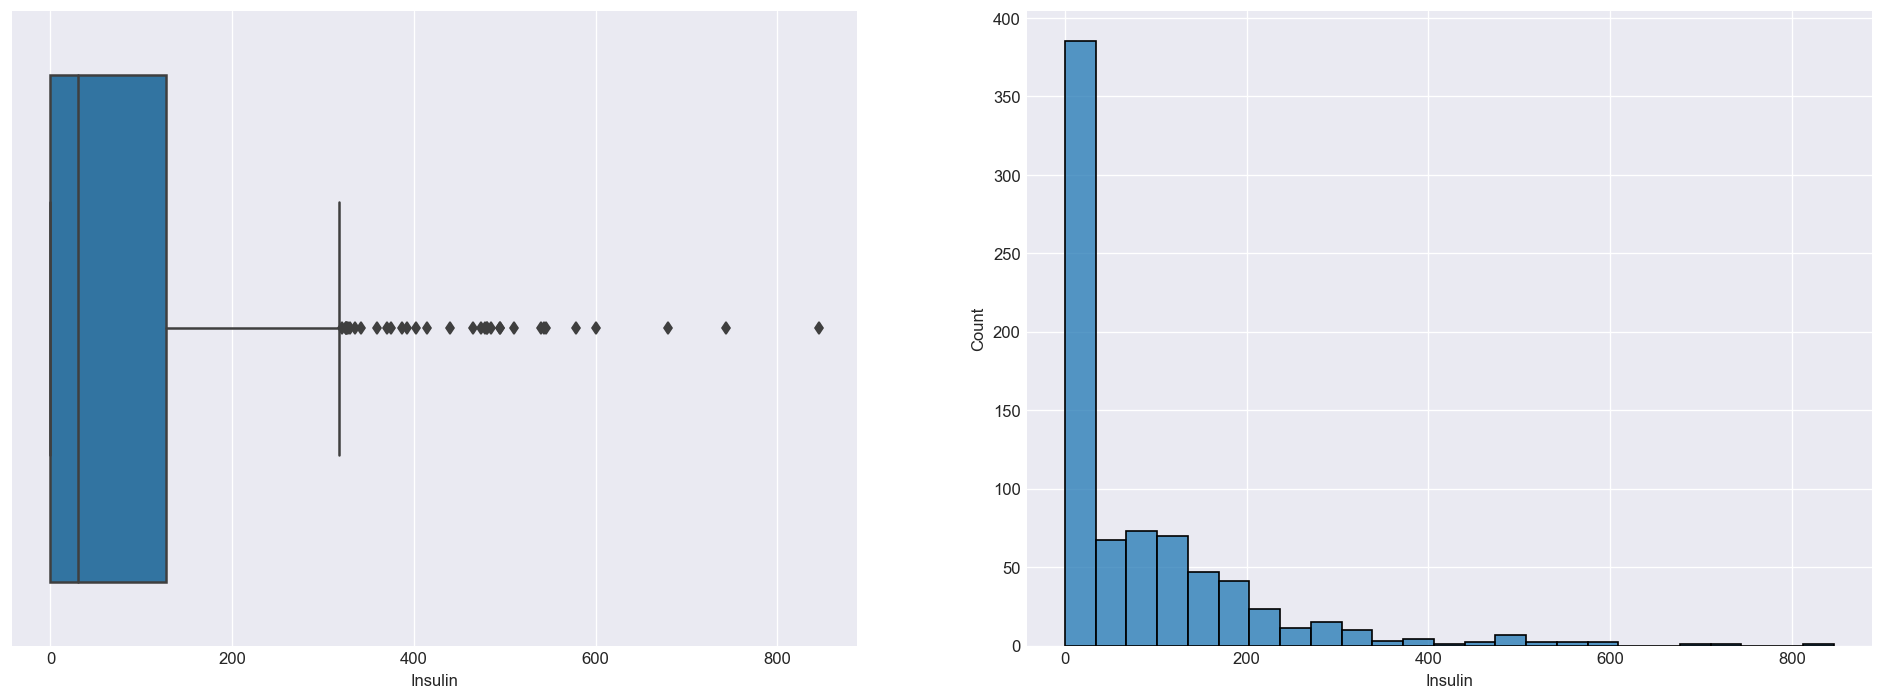

___________________________________________________________________________________________________________
				ANALYSIS OF: BMI 

5 point summary for: BMI
      BMI
min   0.0
25%  27.3
50%  32.0
75%  36.6
max  67.1
---------------------------------
OUTLIERS in BMI via Z score

Outlier limits:
lower limit: 8.355500930379609 
upper limit: 55.62965531962038

Total outliers: 14
     outliers   Z-score
9         0.0 -4.060474
49        0.0 -4.060474
60        0.0 -4.060474
81        0.0 -4.060474
145       0.0 -4.060474
177      67.1  4.455807
371       0.0 -4.060474
426       0.0 -4.060474
445      59.4  3.478529
494       0.0 -4.060474
522       0.0 -4.060474
673      57.3  3.211999
684       0.0 -4.060474
706       0.0 -4.060474
---------------------------------
OUTLIERS in BMI via IQR

Outlier limits:
lower limit: 13.35 
upper limit: 50.550000000000004

Total outliers: 19
9       0.0
49      0.0
60      0.0
81      0.0
120    53.2
125    55.0
145     0.0
177    67.1
193    52.3
247    

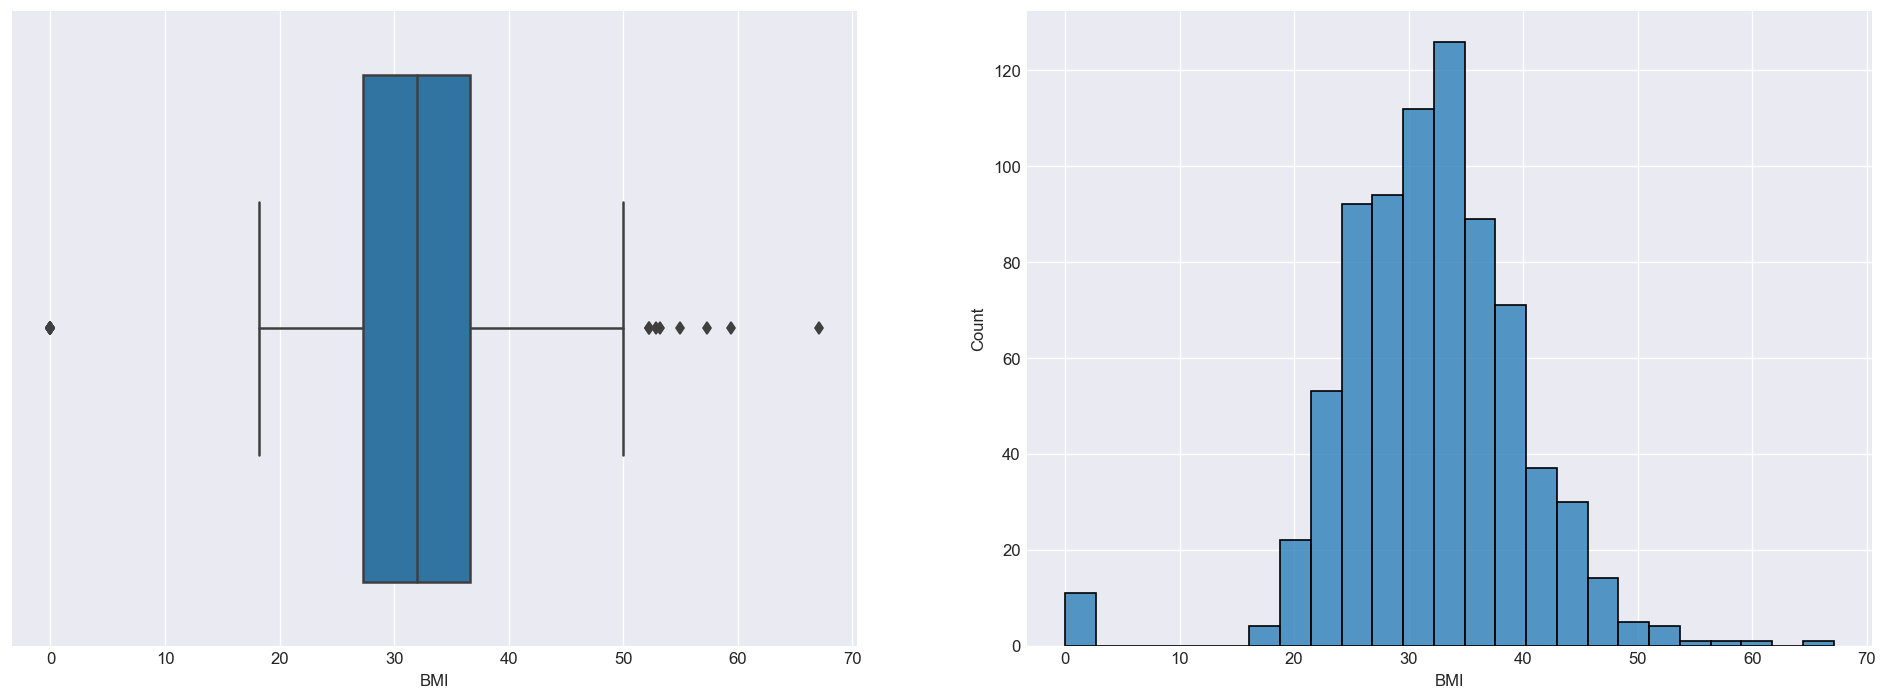

___________________________________________________________________________________________________________
				ANALYSIS OF: DiabetesPedigreeFunction 

5 point summary for: DiabetesPedigreeFunction
     DiabetesPedigreeFunction
min                   0.07800
25%                   0.24375
50%                   0.37250
75%                   0.62625
max                   2.42000
---------------------------------
OUTLIERS in DiabetesPedigreeFunction via Z score

Outlier limits:
lower limit: -0.5214621460025539 
upper limit: 1.4652147501692205

Total outliers: 11
     outliers   Z-score
4       2.288  5.484909
45      1.893  4.291962
58      1.781  3.953709
228     2.329  5.608734
330     1.476  3.032573
370     2.137  5.028871
371     1.731  3.802703
395     1.600  3.407067
445     2.420  5.883565
593     1.699  3.706059
621     1.698  3.703039
---------------------------------
OUTLIERS in DiabetesPedigreeFunction via IQR

Outlier limits:
lower limit: -0.32999999999999996 
upper limit: 1.2


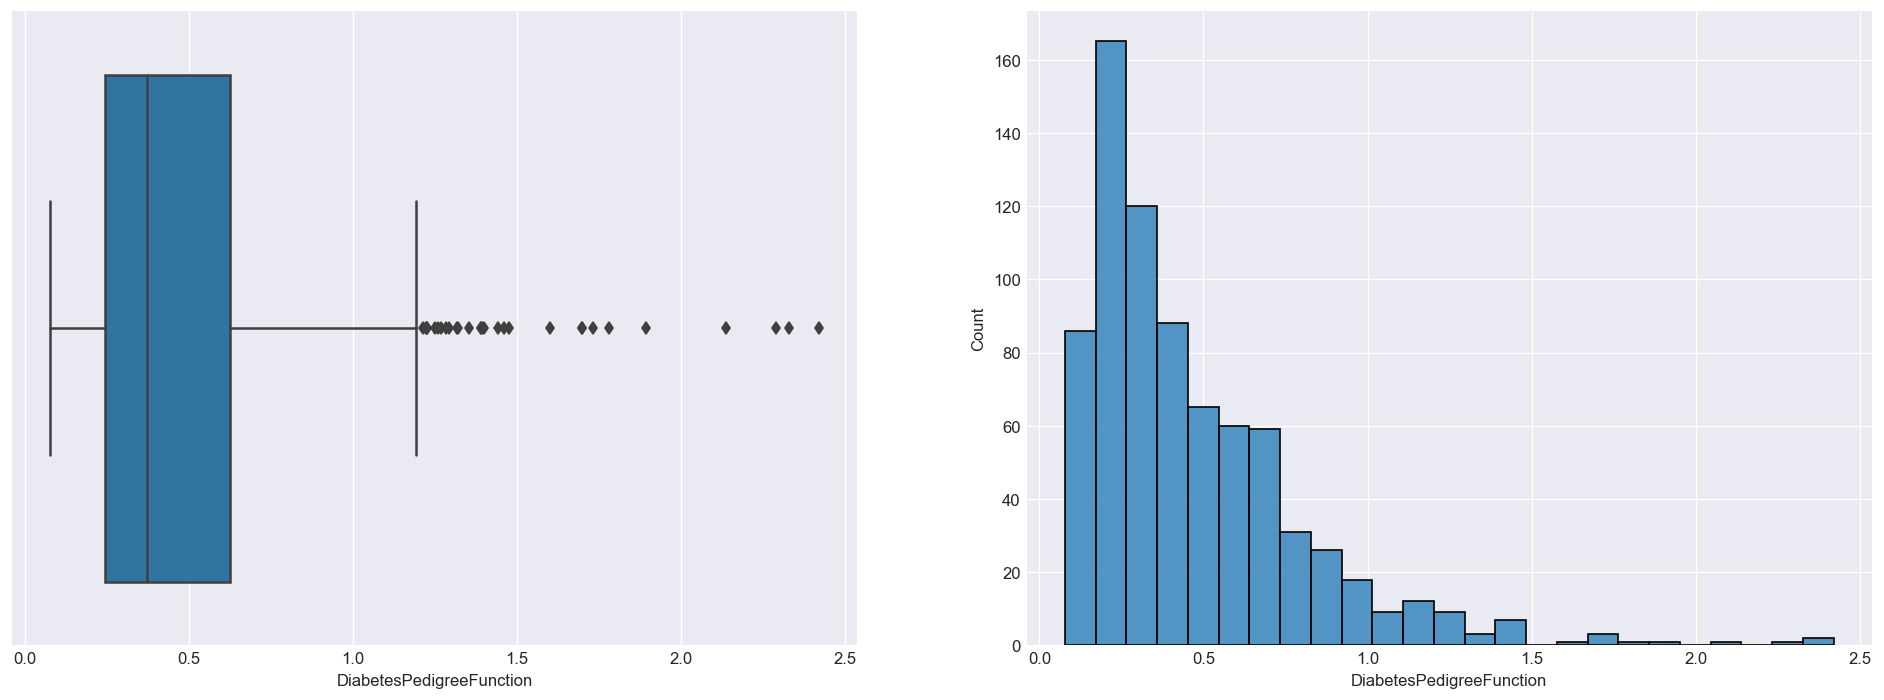

___________________________________________________________________________________________________________
				ANALYSIS OF: Age 

5 point summary for: Age
      Age
min  21.0
25%  24.0
50%  29.0
75%  41.0
max  81.0
---------------------------------
OUTLIERS in Age via Z score

Outlier limits:
lower limit: -2.0168325213158838 
upper limit: 68.49860335464922

Total outliers: 5
     outliers   Z-score
123        69  3.042663
453        72  3.297926
459        81  4.063716
666        70  3.127750
684        69  3.042663
---------------------------------
OUTLIERS in Age via IQR

Outlier limits:
lower limit: -1.5 
upper limit: 66.5

Total outliers: 9
123    69
363    67
453    72
459    81
489    67
537    67
666    70
674    68
684    69
Name: Age, dtype: int64
---------------------------------


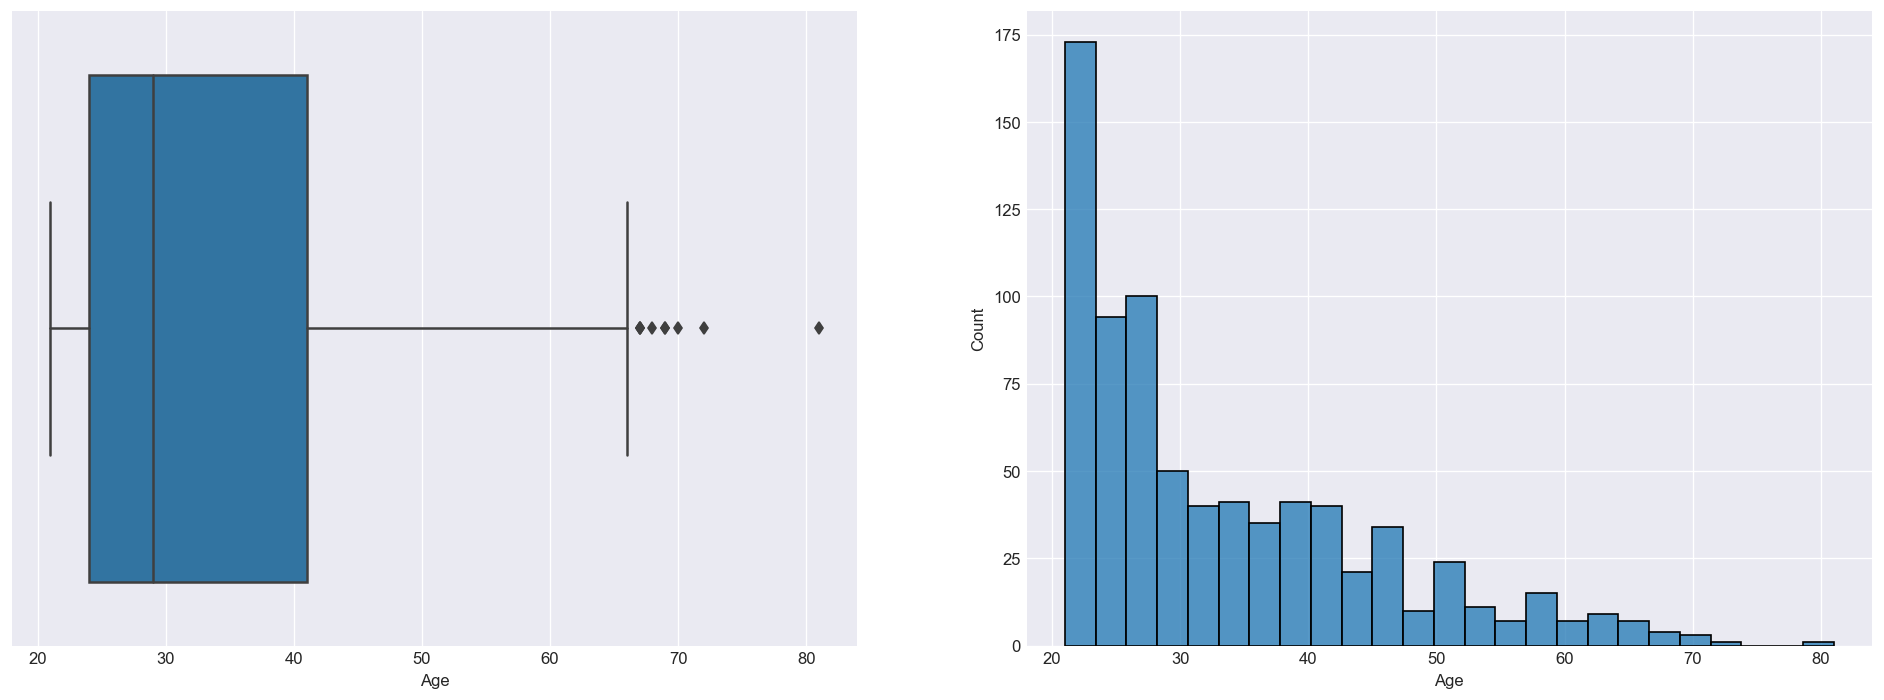

___________________________________________________________________________________________________________


In [10]:
analysis_quant(df, cols_num)

### ***distribution doesn't seem to be normal for some features***

    Some features like glucose, blood pressure, skinthickness, insulin, bmi have values like '0' that is invalid
    Hence we can treat those as NA and fill something else like mean or median for the respective features

In [11]:
df.replace(
    to_replace= {'Glucose': { 0: np.median(df.Glucose) },
                 'BloodPressure': { 0: np.median(df.BloodPressure) },
                 'SkinThickness': { 0: np.median(df.SkinThickness) },
                 'Insulin' : { 0: np.median(df.Insulin) },
                 'BMI' : { 0: np.median(df.BMI) }
                },
    inplace=True
)

    SkinThickness,DiabetesPedigreeFunction,Insulin features seems to have an absurd outlier, it is good to compress it.

In [12]:
# compressing the outliers using Z score
handle_outliers(df, ['SkinThickness','DiabetesPedigreeFunction','Insulin'])

Compressed the following outliers in SkinThickness:
      outliers   Z-score
57         60  3.541727
120        56  3.108029
445        63  3.867001
579        99  7.770285
_____________________________________________________________________________________________________________________
Compressed the following outliers in DiabetesPedigreeFunction:
      outliers   Z-score
4       2.288  5.484909
45      1.893  4.291962
58      1.781  3.953709
228     2.329  5.608734
330     1.476  3.032573
370     2.137  5.028871
371     1.731  3.802703
395     1.600  3.407067
445     2.420  5.883565
593     1.699  3.706059
621     1.698  3.703039
_____________________________________________________________________________________________________________________
Compressed the following outliers in Insulin:
      outliers   Z-score
8       543.0  4.250593
13      846.0  7.123206
111     495.0  3.795525
153     485.0  3.700719
186     495.0  3.795525
220     478.0  3.634355
228     744.0  6.156188


				ANALYSIS OF: Pregnancies 

5 point summary for: Pregnancies
     Pregnancies
min          0.0
25%          1.0
50%          3.0
75%          6.0
max         17.0
---------------------------------
OUTLIERS in Pregnancies via Z score

Outlier limits:
lower limit: -6.257098753893652 
upper limit: 13.94720292056032

Total outliers: 4
     outliers   Z-score
88         15  3.312645
159        17  3.906578
298        14  3.015679
455        14  3.015679
---------------------------------
OUTLIERS in Pregnancies via IQR

Outlier limits:
lower limit: -6.5 
upper limit: 13.5

Total outliers: 4
88     15
159    17
298    14
455    14
Name: Pregnancies, dtype: int64
---------------------------------


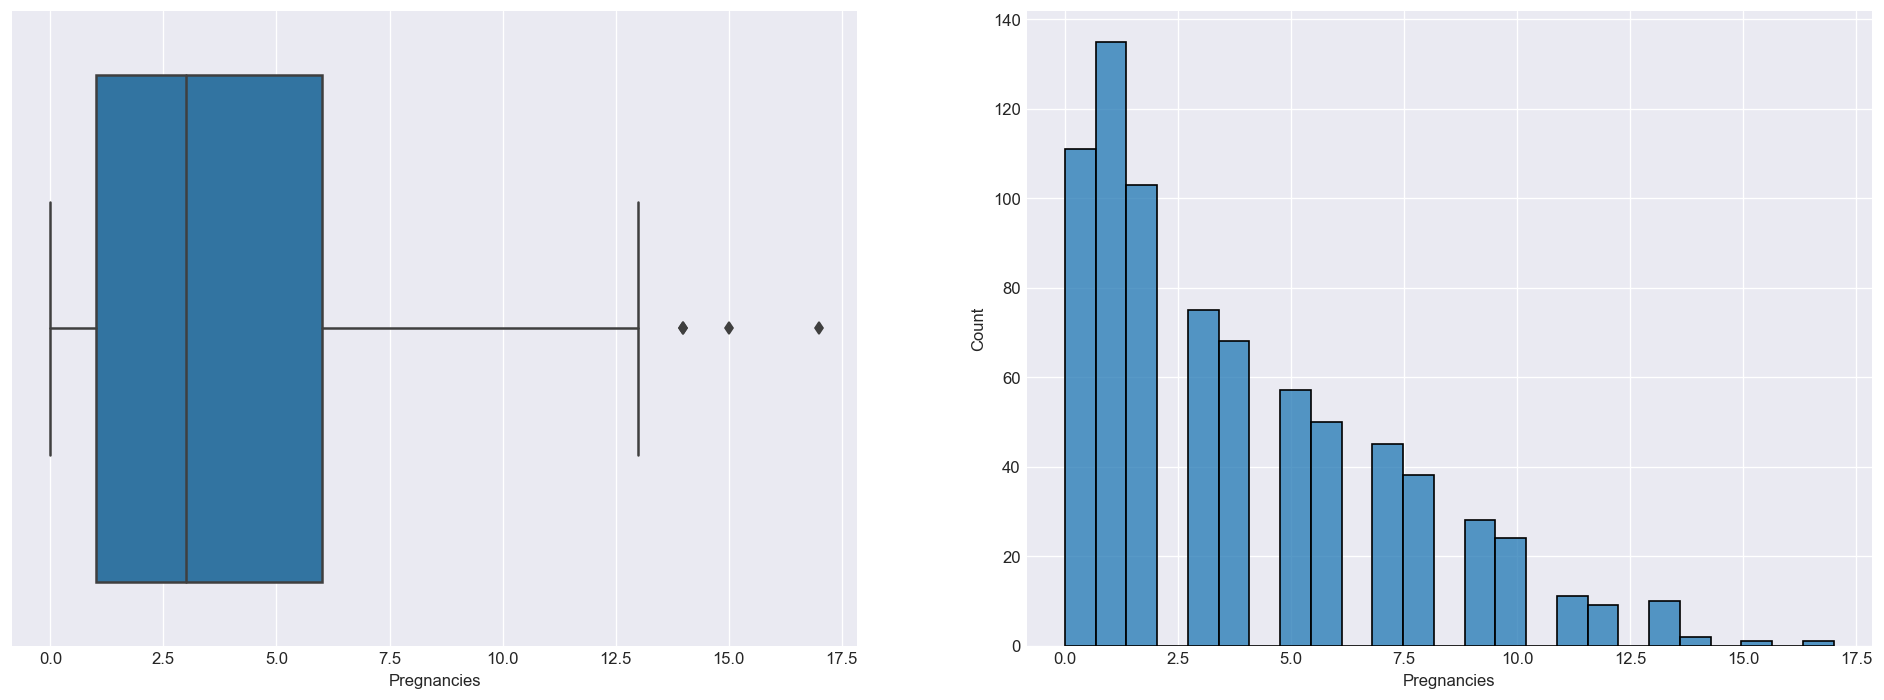

___________________________________________________________________________________________________________
				ANALYSIS OF: Glucose 

5 point summary for: Glucose
     Glucose
min    44.00
25%    99.75
50%   117.00
75%   140.25
max   199.00
---------------------------------
OUTLIERS in Glucose via Z score

Outlier limits:
lower limit: 30.400861674501655 
upper limit: 212.91163832549836

Total outliers: 0
---------------------------------
OUTLIERS in Glucose via IQR

Outlier limits:
lower limit: 39.0 
upper limit: 201.0

Total outliers: 0
---------------------------------


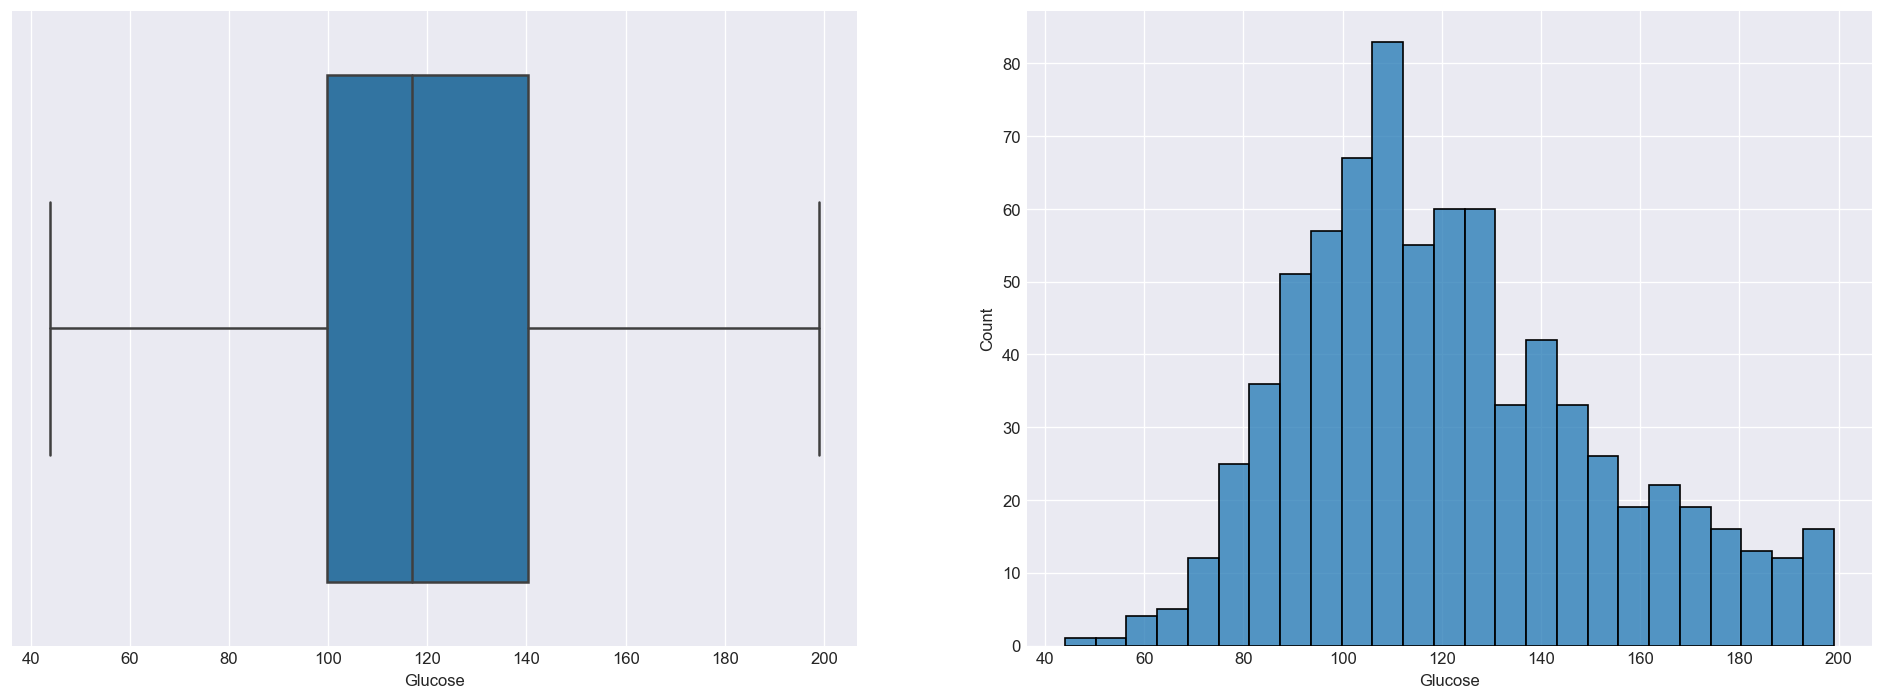

___________________________________________________________________________________________________________
				ANALYSIS OF: BloodPressure 

5 point summary for: BloodPressure
     BloodPressure
min           24.0
25%           64.0
50%           72.0
75%           80.0
max          122.0
---------------------------------
OUTLIERS in BloodPressure via Z score

Outlier limits:
lower limit: 36.12042749730109 
upper limit: 108.65301000269892

Total outliers: 8
     outliers   Z-score
18         30 -3.506291
43        110  3.111425
106       122  4.104082
125        30 -3.506291
177       110  3.111425
549       110  3.111425
597        24 -4.002619
691       114  3.442311
---------------------------------
OUTLIERS in BloodPressure via IQR

Outlier limits:
lower limit: 40.0 
upper limit: 104.0

Total outliers: 14
18      30
43     110
84     108
106    122
125     30
177    110
362    108
549    110
597     24
599     38
658    106
662    106
672    106
691    114
Name: BloodPressure, dtyp

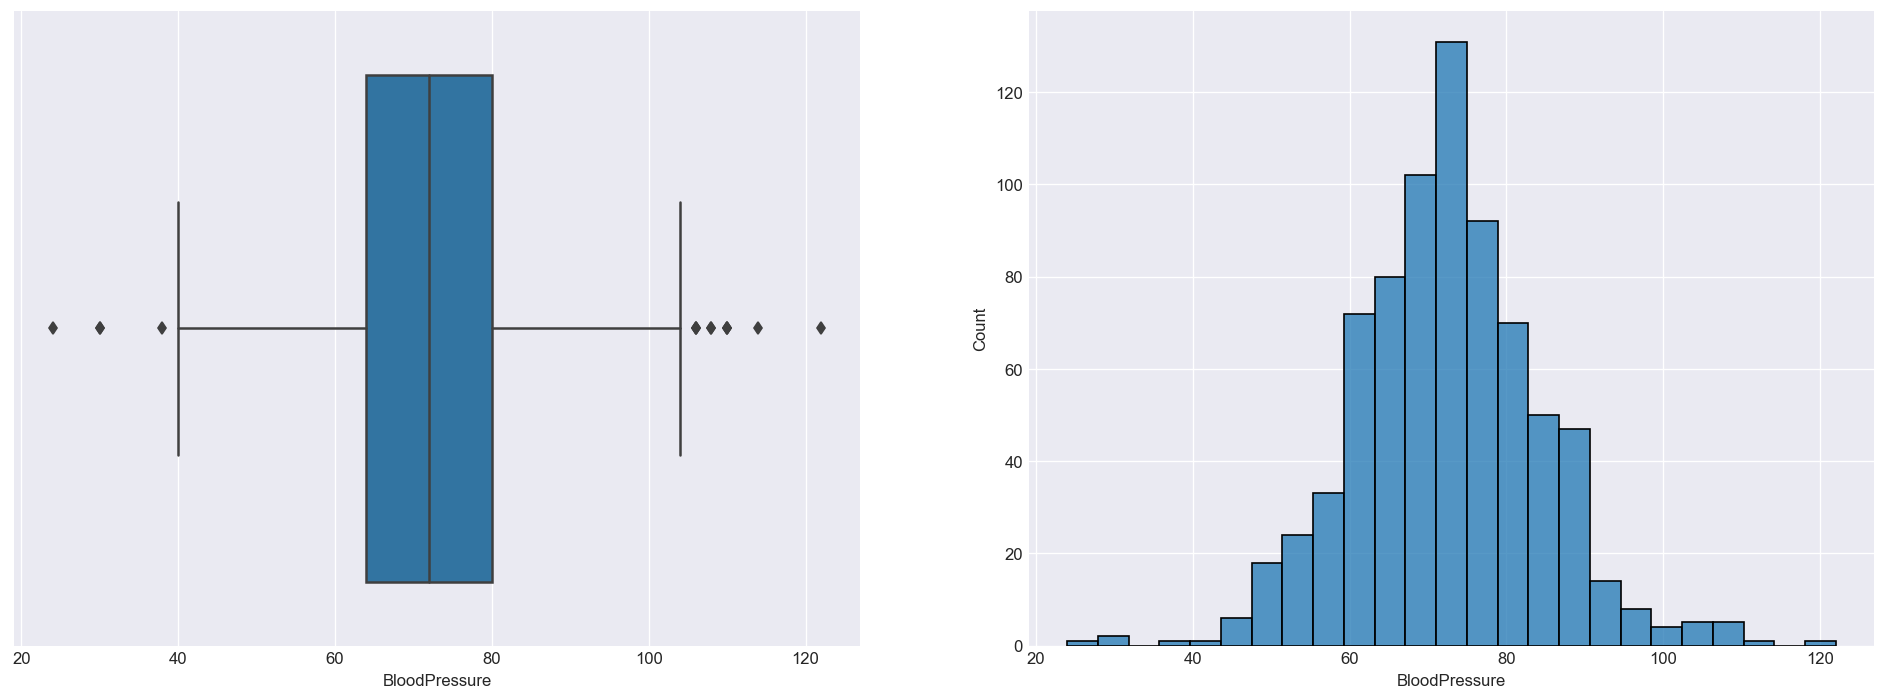

___________________________________________________________________________________________________________
				ANALYSIS OF: SkinThickness 

5 point summary for: SkinThickness
     SkinThickness
min       7.000000
25%      23.000000
50%      23.000000
75%      32.000000
max      55.003647
---------------------------------
OUTLIERS in SkinThickness via Z score

Outlier limits:
lower limit: 0.7226951224964964 
upper limit: 53.79557203403446

Total outliers: 6
      outliers   Z-score
57   55.003647  3.136575
86   54.000000  3.023111
120  55.003647  3.136575
211  54.000000  3.023111
445  55.003647  3.136575
579  55.003647  3.136575
---------------------------------
OUTLIERS in SkinThickness via IQR

Outlier limits:
lower limit: 9.5 
upper limit: 45.5

Total outliers: 35
16     47.000000
39     47.000000
57     55.003647
86     54.000000
99     51.000000
120    55.003647
150    50.000000
177    46.000000
211    54.000000
254     7.000000
273    50.000000
275    52.000000
370    48.000000
3

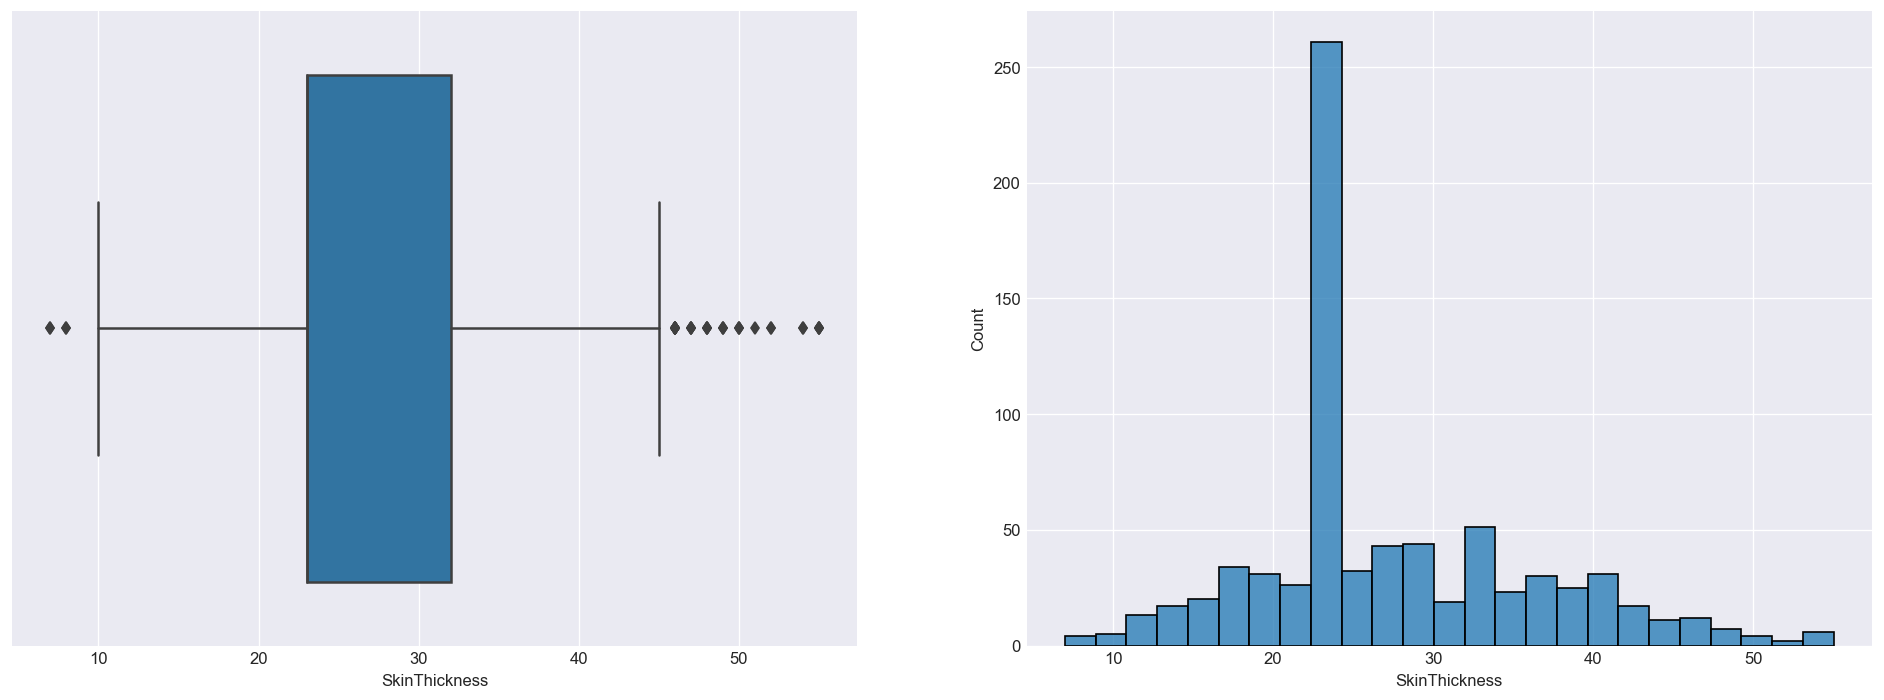

___________________________________________________________________________________________________________
				ANALYSIS OF: Insulin 

5 point summary for: Insulin
        Insulin
min   14.000000
25%   30.500000
50%   31.250000
75%  127.250000
max  411.088924
---------------------------------
OUTLIERS in Insulin via Z score

Outlier limits:
lower limit: -182.99418365383178 
upper limit: 365.8319168852079

Total outliers: 24
       outliers   Z-score
8    411.088924  3.494769
13   411.088924  3.494769
111  411.088924  3.494769
153  411.088924  3.494769
186  411.088924  3.494769
220  411.088924  3.494769
228  411.088924  3.494769
231  370.000000  3.045567
247  411.088924  3.494769
248  402.000000  3.395405
258  375.000000  3.100229
286  411.088924  3.494769
370  411.088924  3.494769
392  411.088924  3.494769
409  411.088924  3.494769
415  411.088924  3.494769
486  411.088924  3.494769
584  411.088924  3.494769
645  411.088924  3.494769
655  411.088924  3.494769
695  411.088924  3.494769


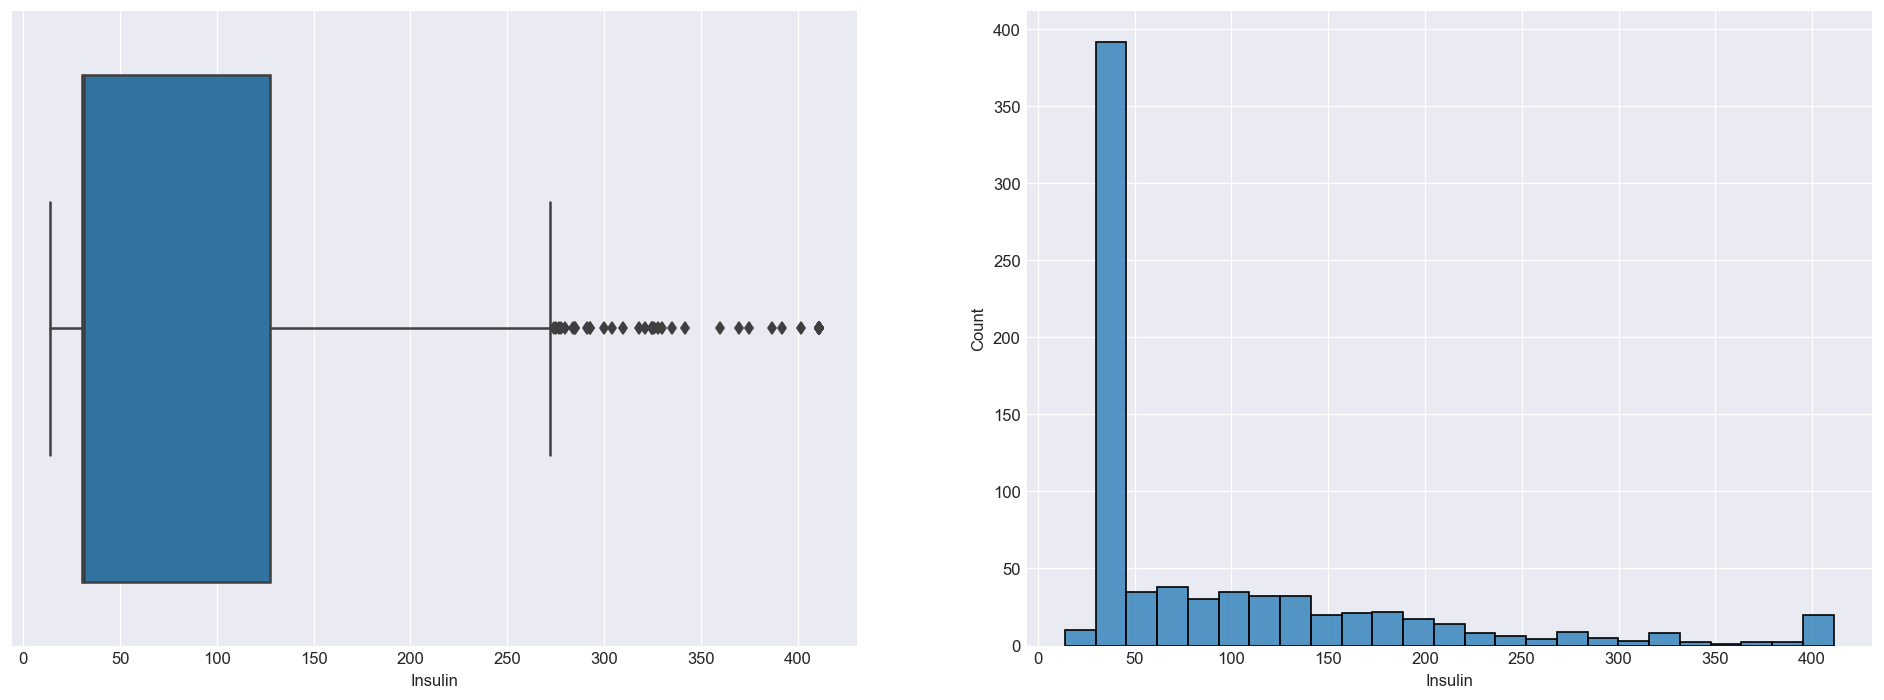

___________________________________________________________________________________________________________
				ANALYSIS OF: BMI 

5 point summary for: BMI
      BMI
min  18.2
25%  27.5
50%  32.0
75%  36.6
max  67.1
---------------------------------
OUTLIERS in BMI via Z score

Outlier limits:
lower limit: 11.838244872634299 
upper limit: 53.06357804403236

Total outliers: 5
     outliers   Z-score
120      53.2  3.019855
125      55.0  3.281830
177      67.1  5.042883
445      59.4  3.922213
673      57.3  3.616576
---------------------------------
OUTLIERS in BMI via IQR

Outlier limits:
lower limit: 13.849999999999998 
upper limit: 50.25

Total outliers: 8
120    53.2
125    55.0
177    67.1
193    52.3
247    52.3
303    52.9
445    59.4
673    57.3
Name: BMI, dtype: float64
---------------------------------


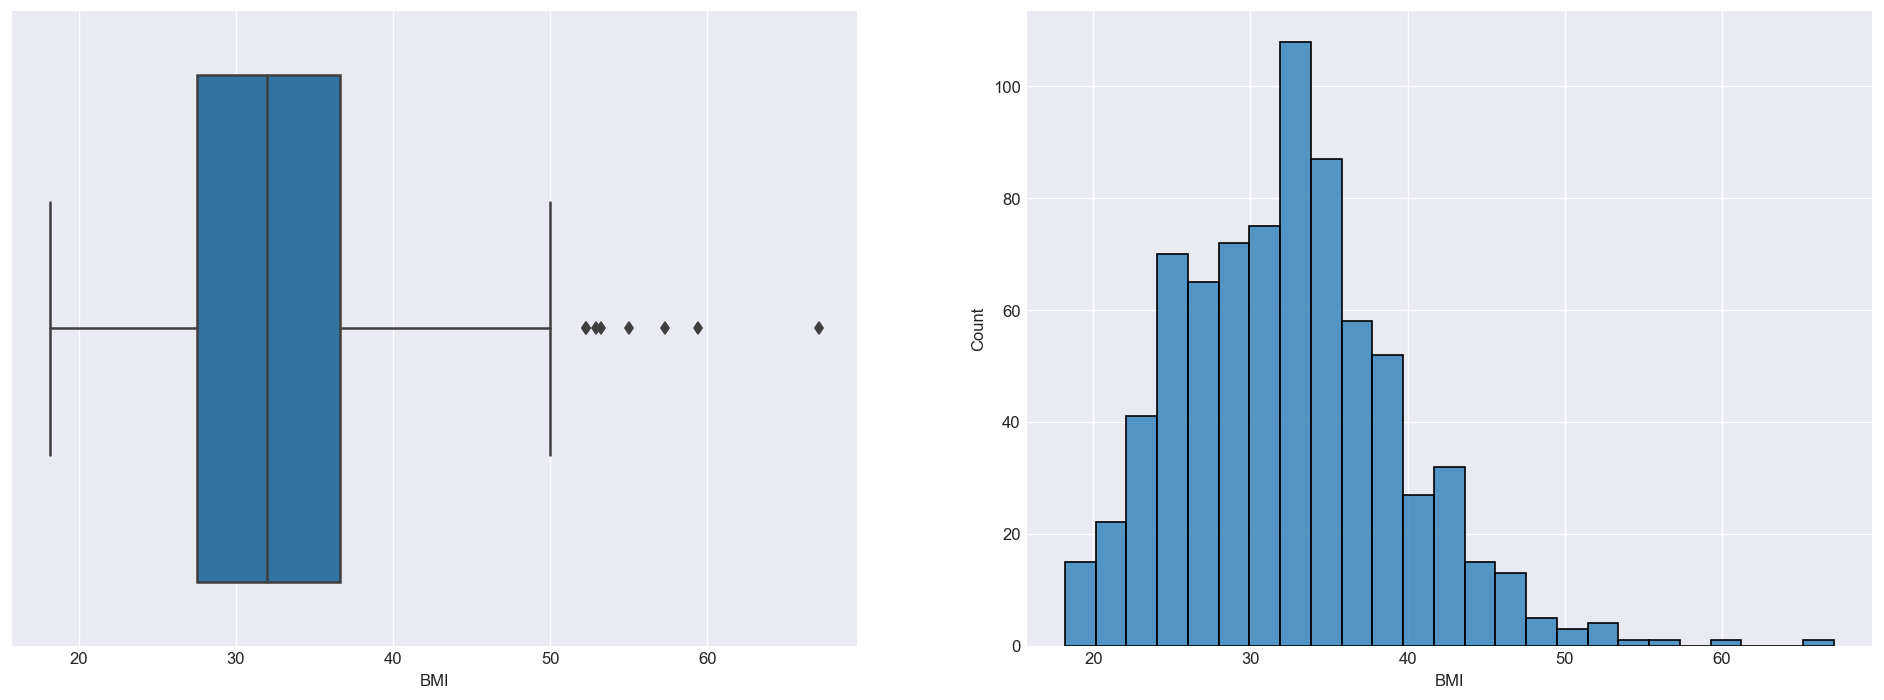

___________________________________________________________________________________________________________
				ANALYSIS OF: DiabetesPedigreeFunction 

5 point summary for: DiabetesPedigreeFunction
     DiabetesPedigreeFunction
min                  0.078000
25%                  0.243750
50%                  0.372500
75%                  0.626250
max                  1.465215
---------------------------------
OUTLIERS in DiabetesPedigreeFunction via Z score

Outlier limits:
lower limit: -0.4473388381956631 
upper limit: 1.3782408232265524

Total outliers: 17
     outliers   Z-score
4    1.465215  3.285851
12   1.441000  3.206266
39   1.390000  3.038648
45   1.465215  3.285851
58   1.465215  3.285851
147  1.400000  3.071514
228  1.465215  3.285851
308  1.391000  3.041935
330  1.465215  3.285851
370  1.465215  3.285851
371  1.465215  3.285851
395  1.465215  3.285851
445  1.465215  3.285851
593  1.465215  3.285851
621  1.465215  3.285851
622  1.461000  3.271999
661  1.394000  3.051795
----

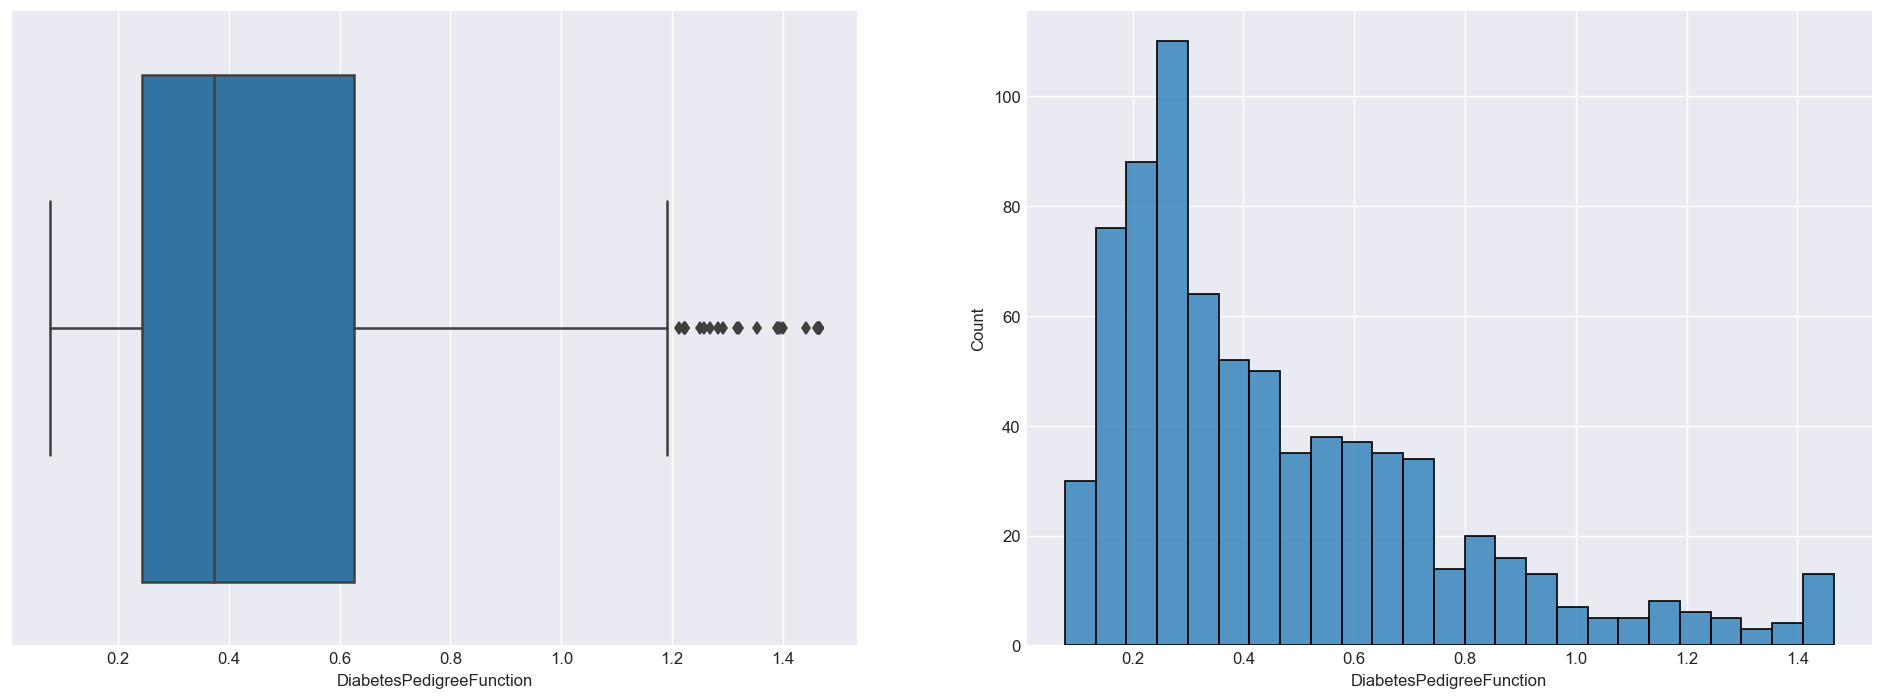

___________________________________________________________________________________________________________
				ANALYSIS OF: Age 

5 point summary for: Age
      Age
min  21.0
25%  24.0
50%  29.0
75%  41.0
max  81.0
---------------------------------
OUTLIERS in Age via Z score

Outlier limits:
lower limit: -2.0168325213158838 
upper limit: 68.49860335464922

Total outliers: 5
     outliers   Z-score
123        69  3.042663
453        72  3.297926
459        81  4.063716
666        70  3.127750
684        69  3.042663
---------------------------------
OUTLIERS in Age via IQR

Outlier limits:
lower limit: -1.5 
upper limit: 66.5

Total outliers: 9
123    69
363    67
453    72
459    81
489    67
537    67
666    70
674    68
684    69
Name: Age, dtype: int64
---------------------------------


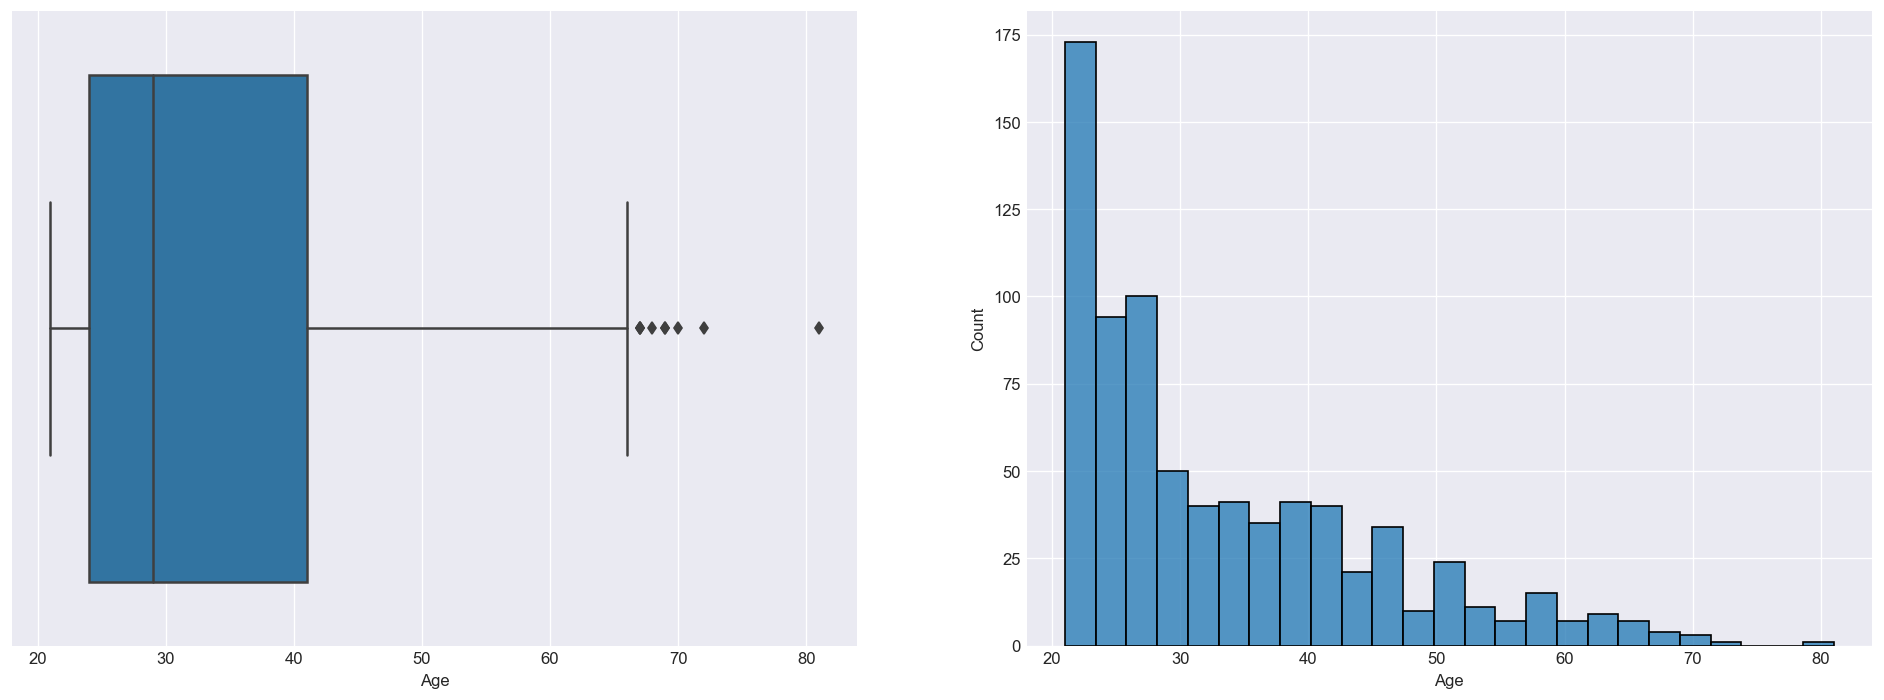

___________________________________________________________________________________________________________


In [13]:
analysis_quant(df, cols_num)

    Now most of the distributions look like normal distribution.
    Some features like DiabetesPedigreeFunction exponential distribution.
    Age seems to follow and exponential distribution.
    Pregnancies seems to be a discreet feature. 

## **BIVARIATE ANALYSIS**

### Correlation between features

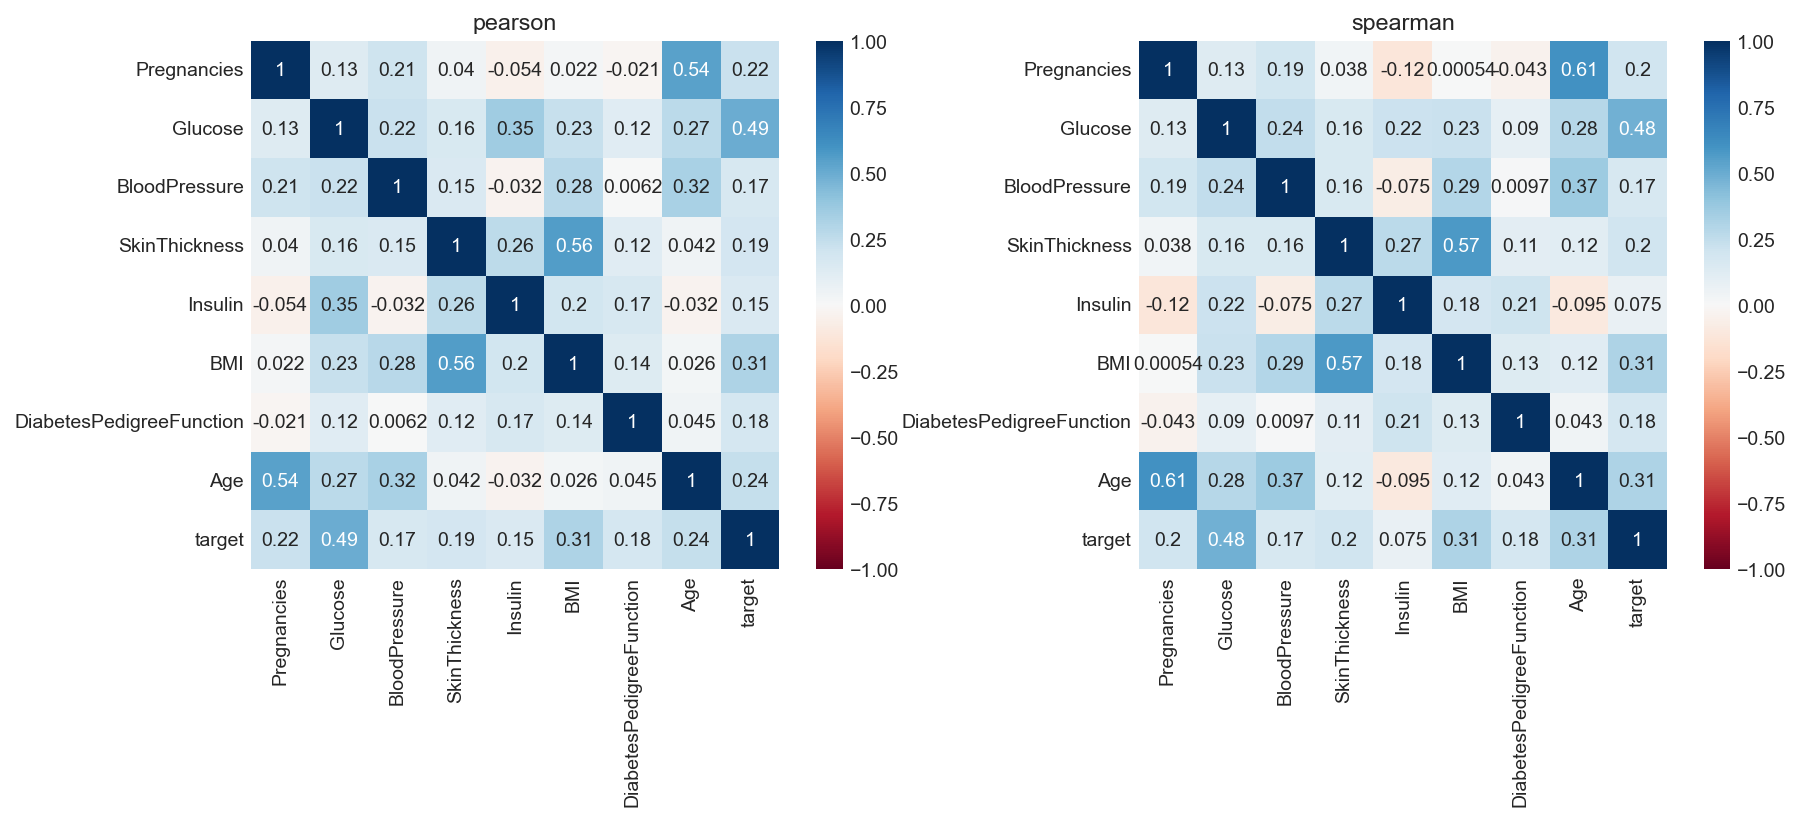

In [14]:
correlation(df, figsize=(15,5), dpi=140)

    There doesnt seem to be any significant correlation between features

### analysing discrete features  

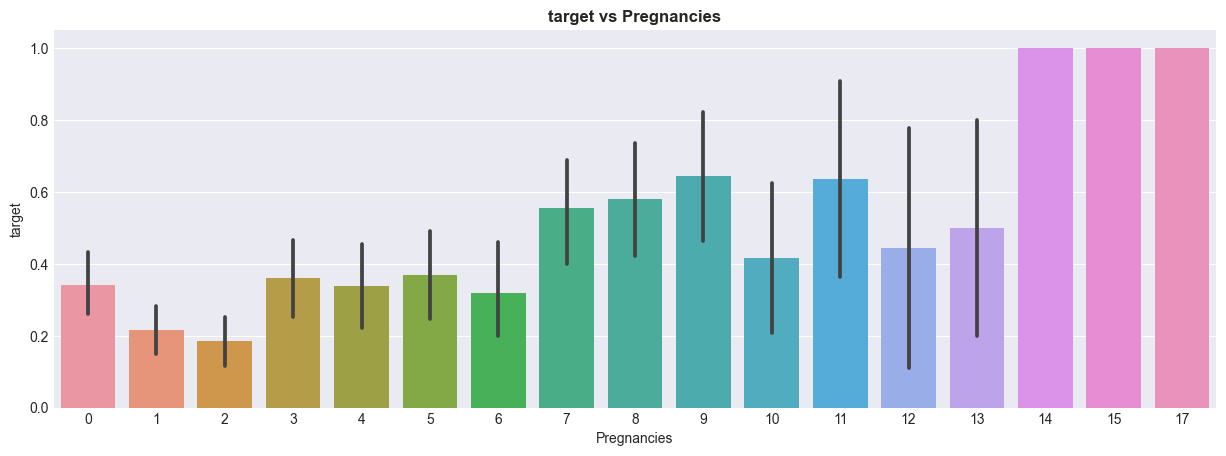

In [15]:
plt.figure(figsize=(15,5), dpi=100)
plt.title(f'target vs Pregnancies', fontweight='bold')
sns.barplot(x='Pregnancies', y="target", data=df, estimator=np.mean )
plt.show()

### ***seems like people with 14 pregnancies and higher have 100% chance of diabetes***
### ***this may be due to less data points in that range***

### analysing continuous features  

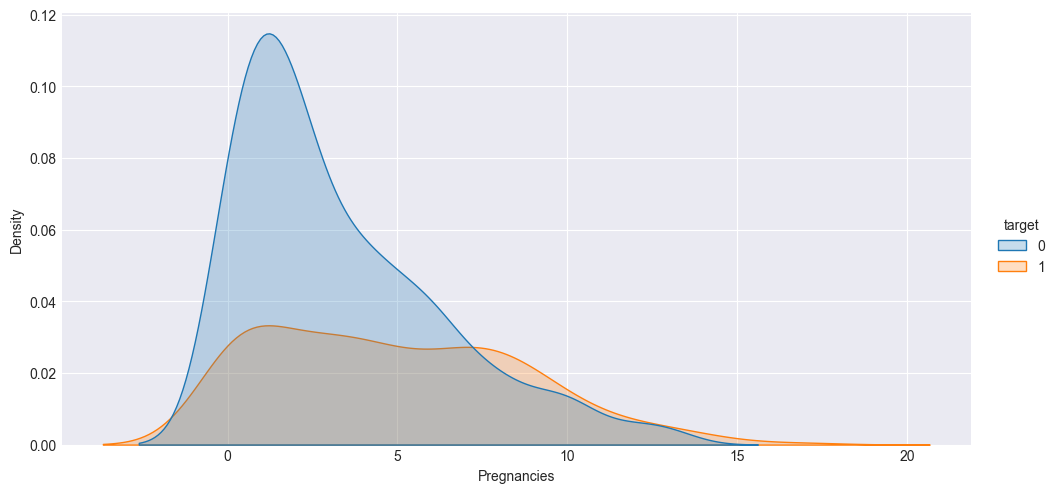

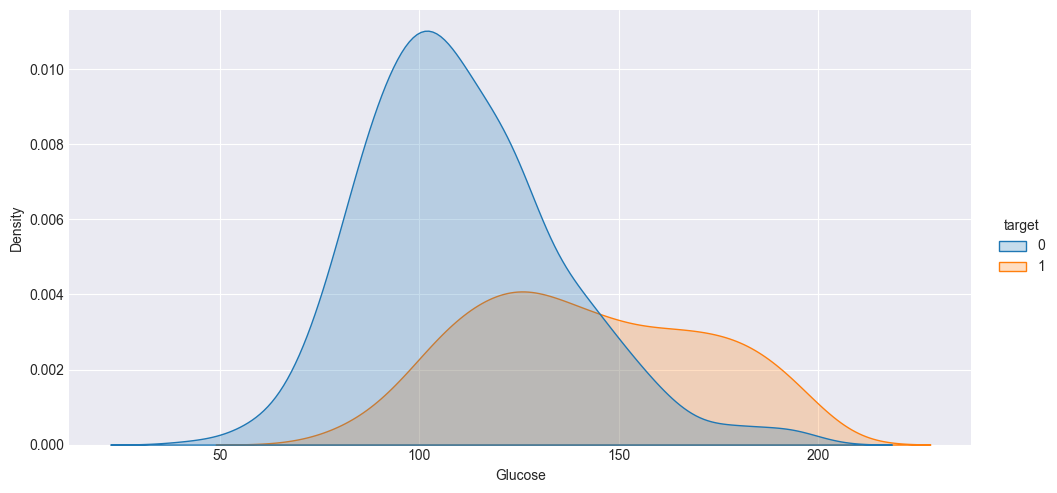

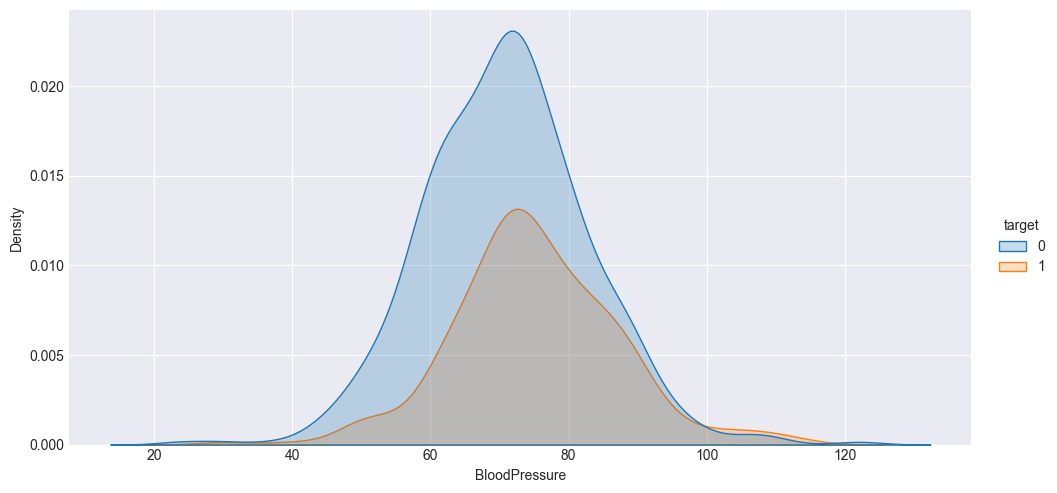

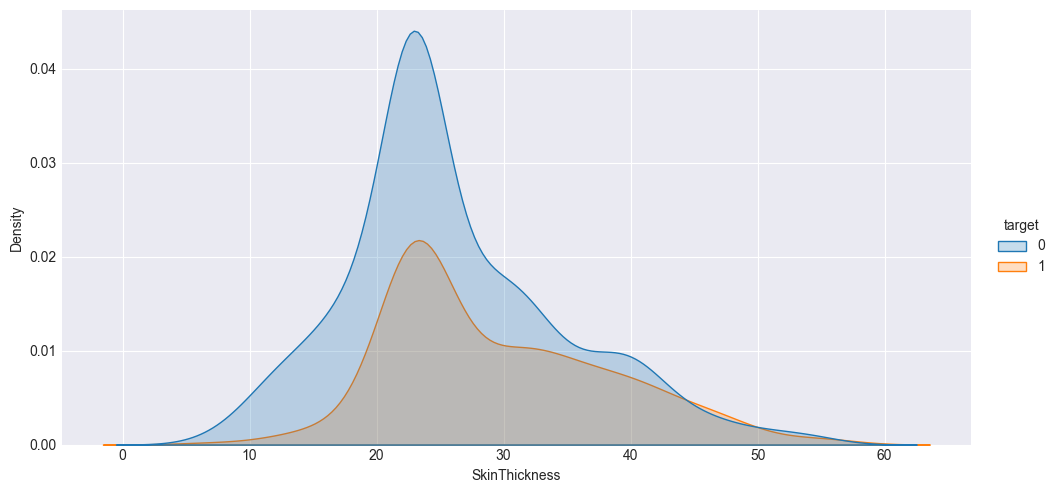

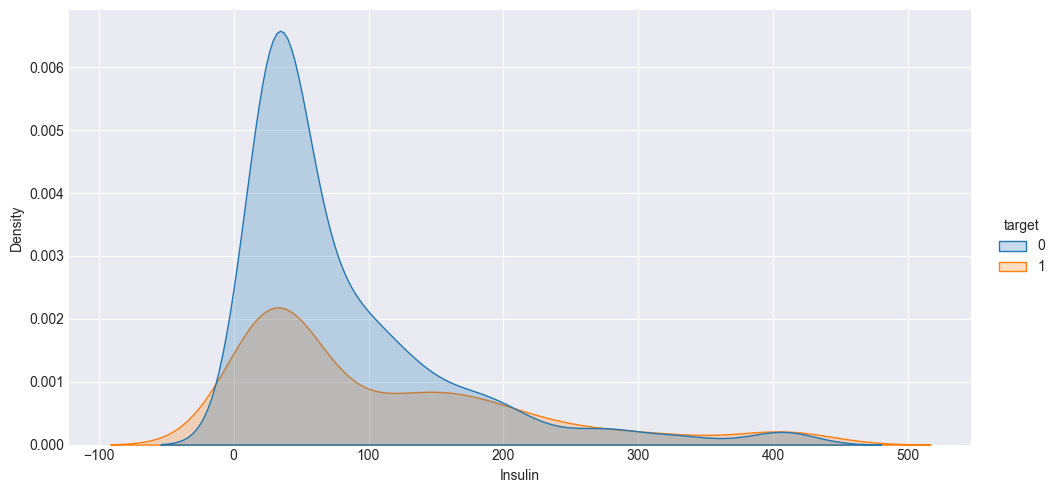

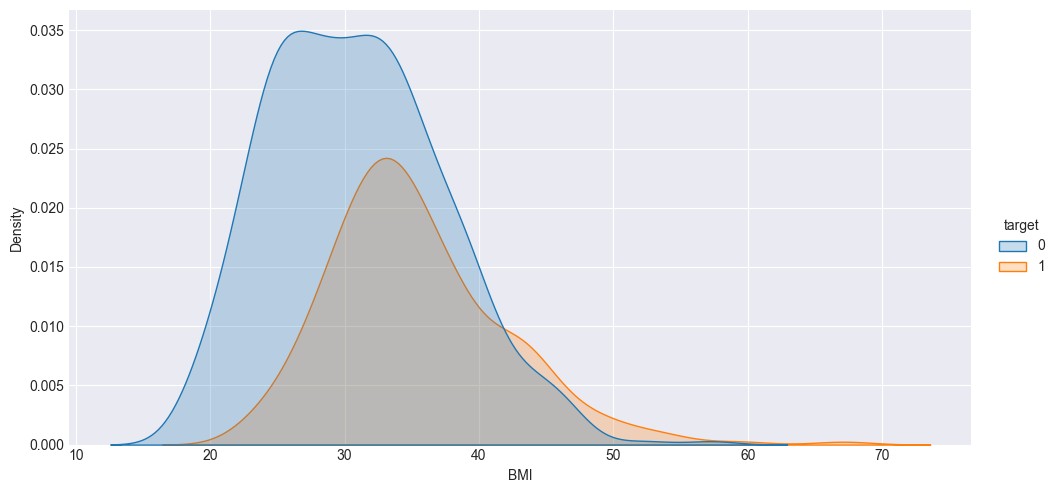

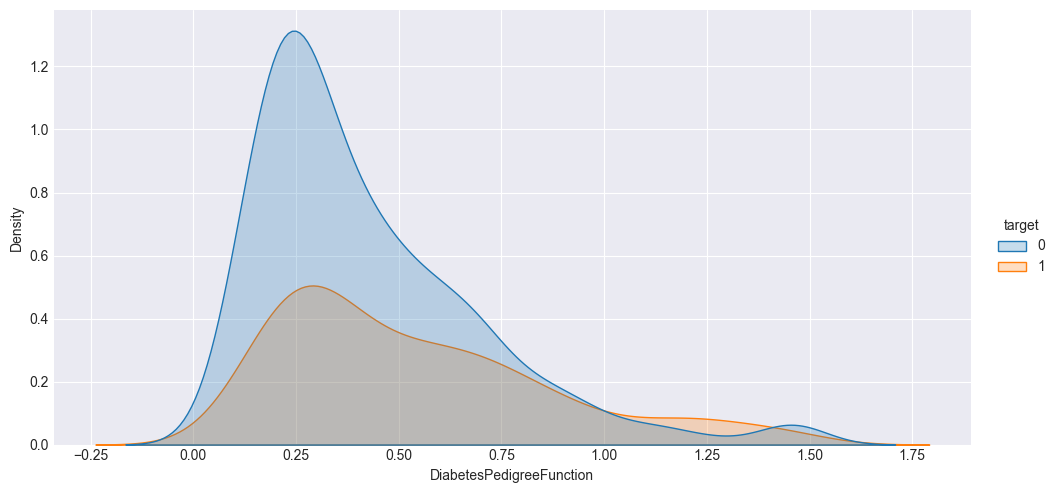

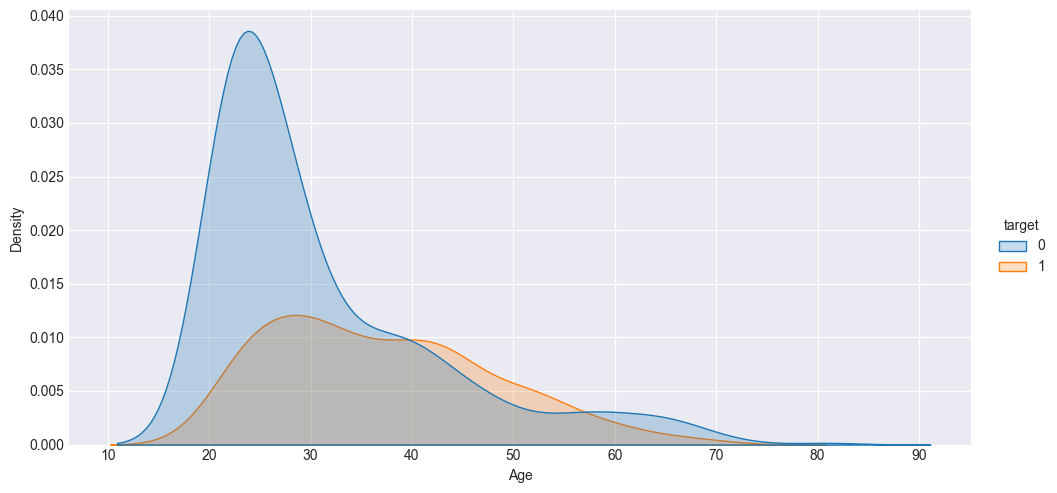

In [16]:
for col in df.drop(columns='target', axis=1).columns:
    
    plot=sns.displot(
        data=df,
        x=col,
        hue='target',
        kind='kde',
        aspect=2, fill=True
    )
    
    plot.fig.dpi=100

### ***Clearly looks like people with high glucose had higher chances of diabetes***

## **Multivariate analysis**

# **MODELS AND PIPELINES**

##### separating features and label

In [17]:
X=df.drop('target', axis=1)
y=df.target

In [18]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,target
0,6,148,72,35.0,30.5,33.6,0.627000,50,1
1,1,85,66,29.0,30.5,26.6,0.351000,31,0
2,8,183,64,23.0,30.5,23.3,0.672000,32,1
3,1,89,66,23.0,94.0,28.1,0.167000,21,0
4,0,137,40,35.0,168.0,43.1,1.465215,33,1


##### train test split

In [19]:
# although CV score is being used, this split is needed for making confusion matrix
xtrain,xtest,ytrain,ytest=train_test_split(X,y)

### defining models

In [20]:
model_lr=LogisticRegression(n_jobs=-1, C=0.07)

model_dt=DecisionTreeClassifier(max_depth=6, min_samples_split=50 )   

model_rf=RandomForestClassifier(n_jobs=-1, max_features=0.5, max_depth=6, min_samples_split=50)    

model_ada_dt=AdaBoostClassifier( base_estimator=DecisionTreeClassifier(max_depth=6, min_samples_split=50), n_estimators=100, learning_rate=5)   

model_ada_rf=AdaBoostClassifier(base_estimator=RandomForestClassifier(n_jobs=-1, max_features=0.5, max_depth=6, min_samples_split=50), n_estimators=50, learning_rate=0.1)  

model_gb=GradientBoostingClassifier(max_depth=6, min_samples_split=50)

model_svc=SVC(C=0.1, degree=5, probability=True )   

model_gnb=GaussianNB()

model_knc=KNeighborsClassifier(n_neighbors=5, n_jobs=-1, weights='distance')   

model_rnc=RadiusNeighborsClassifier(radius=5, n_jobs=-1, weights='distance')  

model_xgb=XGBClassifier(n_estimators=500, learning_rate=0.1, n_jobs=-1)

# dictionary of all models
models={'logistic':model_lr, 'decision tree':model_dt, 'random forest':model_rf, 'adaboost using dt':model_ada_dt, 'adaboost using rf':model_ada_rf,
        'gradboost':model_gb, 'SVC':model_svc, 'Gaussian NB':model_gnb, 'KNC':model_knc, 'RNC':model_rnc, 'xgboost':model_xgb }

### pipeline and scores

LOGISTIC model:

train accuracy:  0.6996527777777778
test accuracy:  0.6770833333333334
cross validation f1 score: 0.3687918673636316

classification report:
               precision    recall  f1-score   support

           0       0.66      0.99      0.79       120
           1       0.92      0.15      0.26        72

    accuracy                           0.68       192
   macro avg       0.79      0.57      0.53       192
weighted avg       0.76      0.68      0.59       192



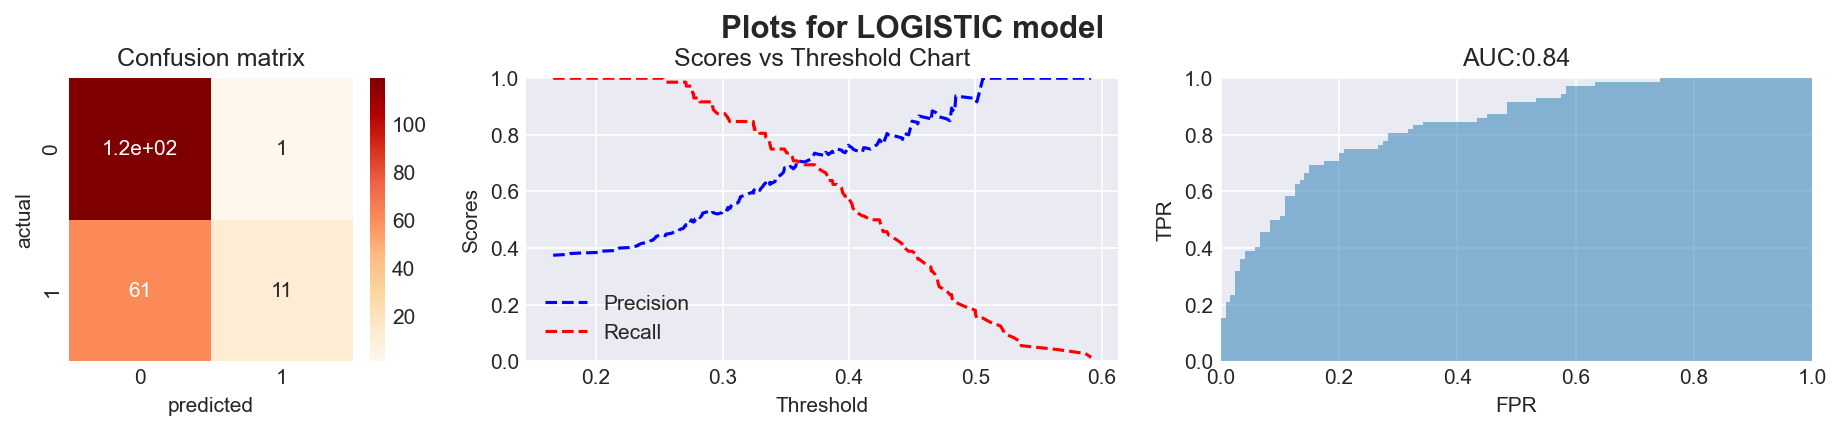

__________________________________________________________________________
DECISION TREE model:

train accuracy:  0.8229166666666666
test accuracy:  0.7447916666666666
cross validation f1 score: 0.6008895819675867

classification report:
               precision    recall  f1-score   support

           0       0.74      0.91      0.82       120
           1       0.76      0.47      0.58        72

    accuracy                           0.74       192
   macro avg       0.75      0.69      0.70       192
weighted avg       0.75      0.74      0.73       192



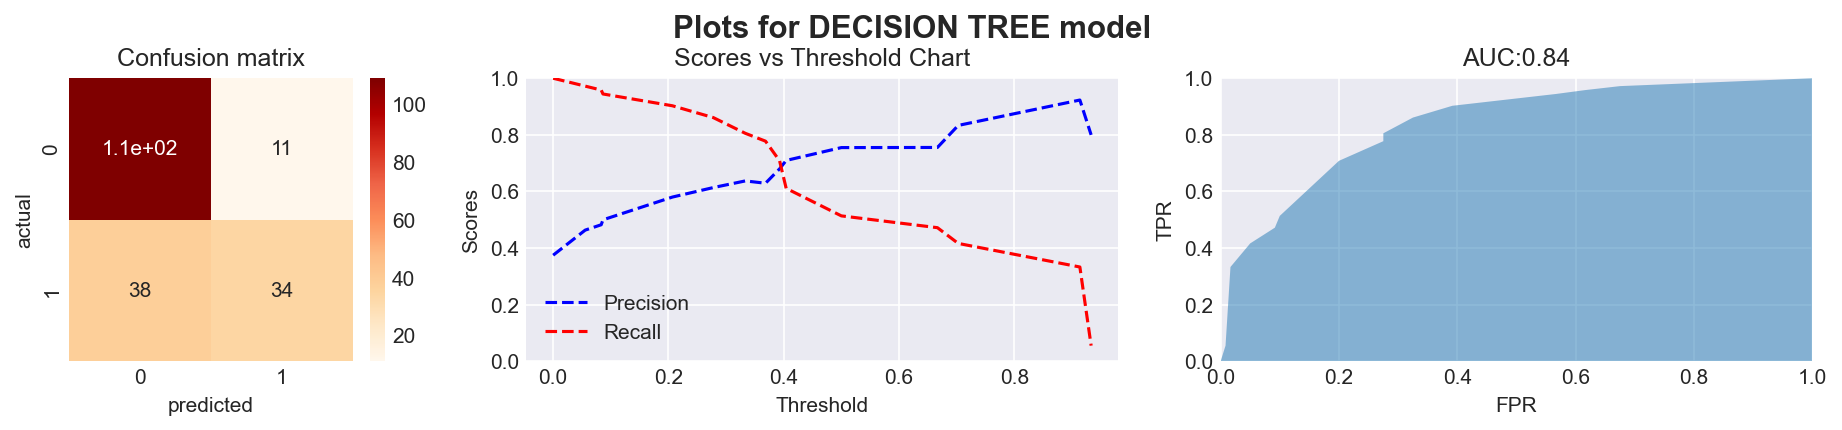

__________________________________________________________________________
RANDOM FOREST model:

train accuracy:  0.8263888888888888
test accuracy:  0.7604166666666666
cross validation f1 score: 0.6218493849780282

classification report:
               precision    recall  f1-score   support

           0       0.77      0.88      0.82       120
           1       0.73      0.57      0.64        72

    accuracy                           0.76       192
   macro avg       0.75      0.72      0.73       192
weighted avg       0.76      0.76      0.75       192



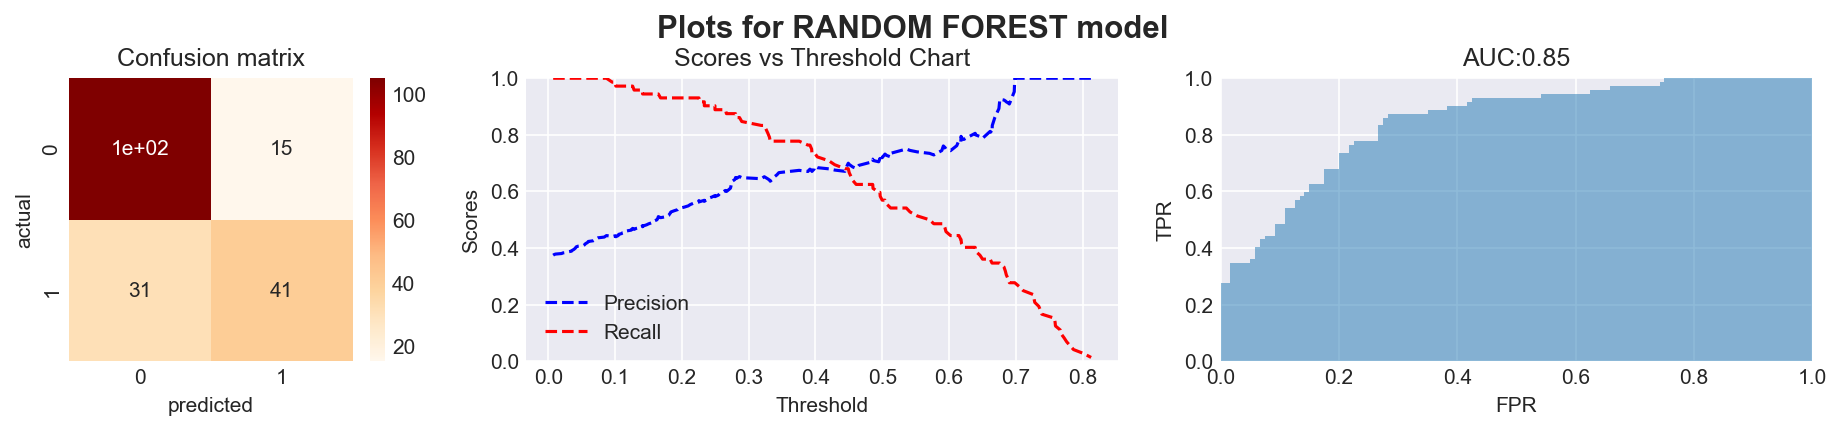

__________________________________________________________________________
ADABOOST USING DT model:

train accuracy:  0.6822916666666666
test accuracy:  0.6302083333333334
cross validation f1 score: 0.18356312562705718

classification report:
               precision    recall  f1-score   support

           0       0.63      0.99      0.77       120
           1       0.67      0.03      0.05        72

    accuracy                           0.63       192
   macro avg       0.65      0.51      0.41       192
weighted avg       0.64      0.63      0.50       192



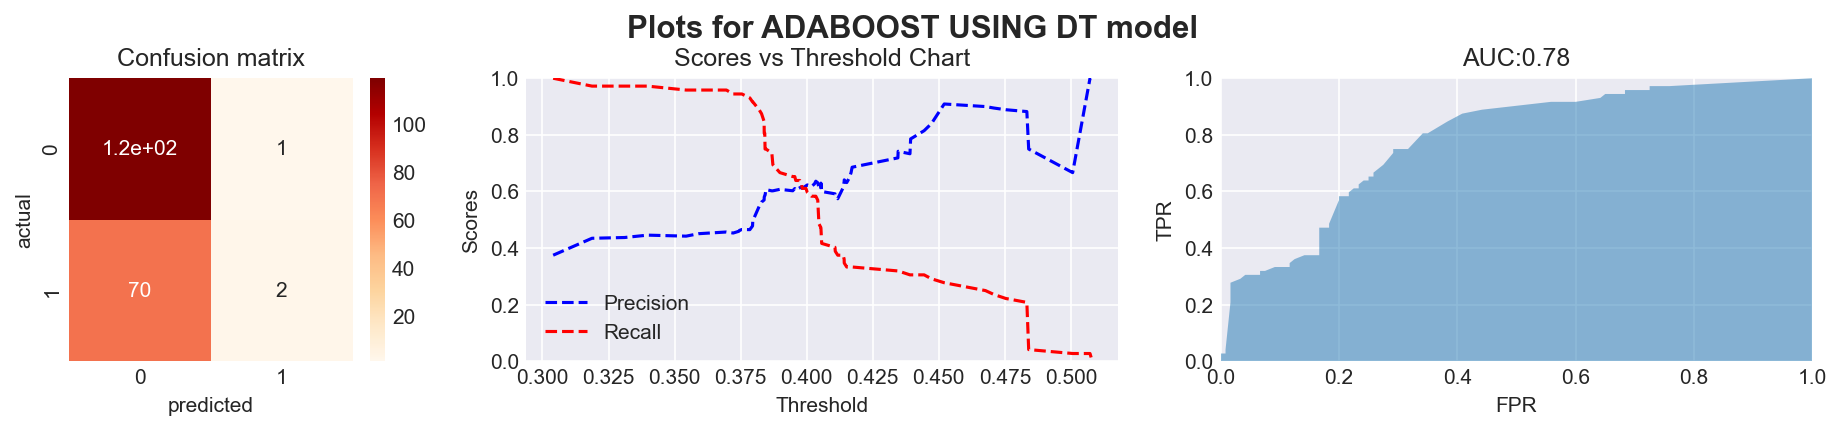

__________________________________________________________________________
ADABOOST USING RF model:

train accuracy:  0.9184027777777778
test accuracy:  0.765625
cross validation f1 score: 0.644256146891285

classification report:
               precision    recall  f1-score   support

           0       0.80      0.84      0.82       120
           1       0.71      0.64      0.67        72

    accuracy                           0.77       192
   macro avg       0.75      0.74      0.74       192
weighted avg       0.76      0.77      0.76       192



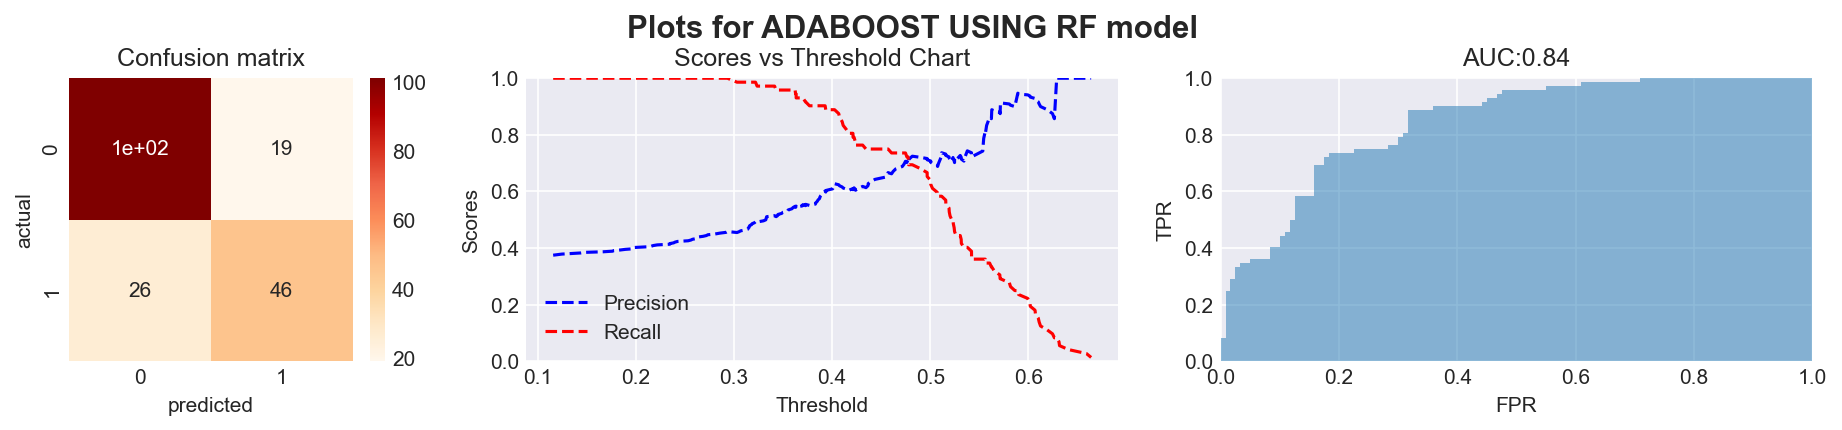

__________________________________________________________________________
GRADBOOST model:

train accuracy:  1.0
test accuracy:  0.7552083333333334
cross validation f1 score: 0.6225688251795353

classification report:
               precision    recall  f1-score   support

           0       0.78      0.84      0.81       120
           1       0.70      0.61      0.65        72

    accuracy                           0.76       192
   macro avg       0.74      0.73      0.73       192
weighted avg       0.75      0.76      0.75       192



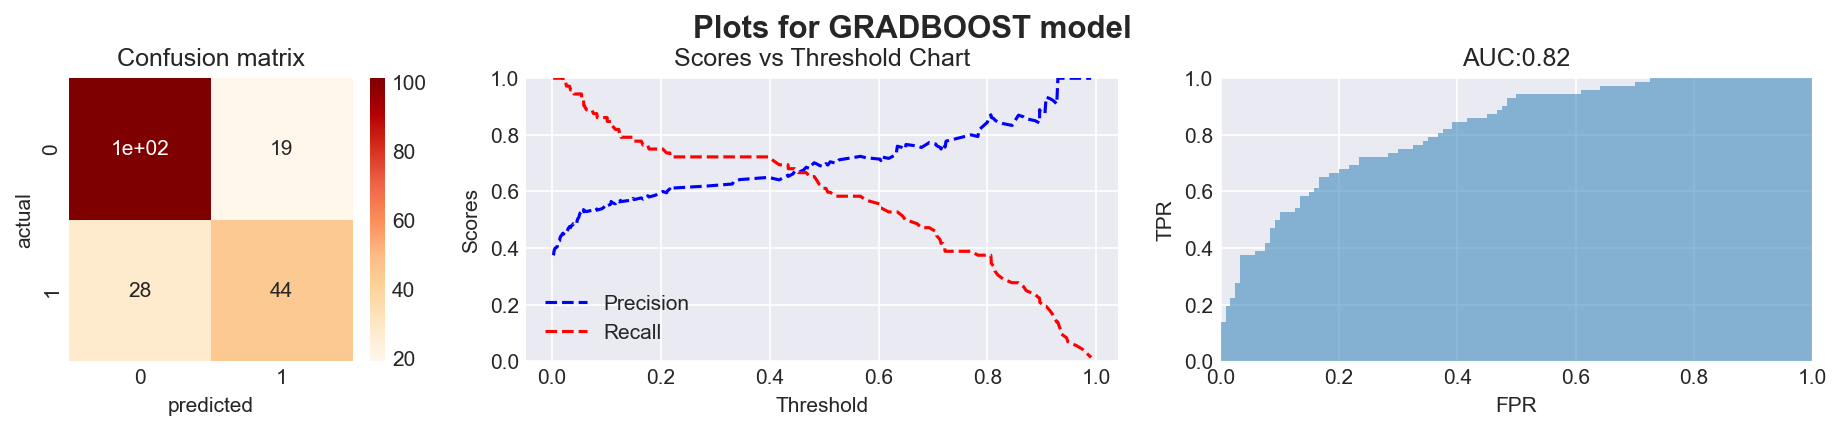

__________________________________________________________________________
SVC model:

train accuracy:  0.7586805555555556
test accuracy:  0.75
cross validation f1 score: 0.588588219657011

classification report:
               precision    recall  f1-score   support

           0       0.73      0.94      0.82       120
           1       0.82      0.43      0.56        72

    accuracy                           0.75       192
   macro avg       0.77      0.69      0.69       192
weighted avg       0.76      0.75      0.73       192



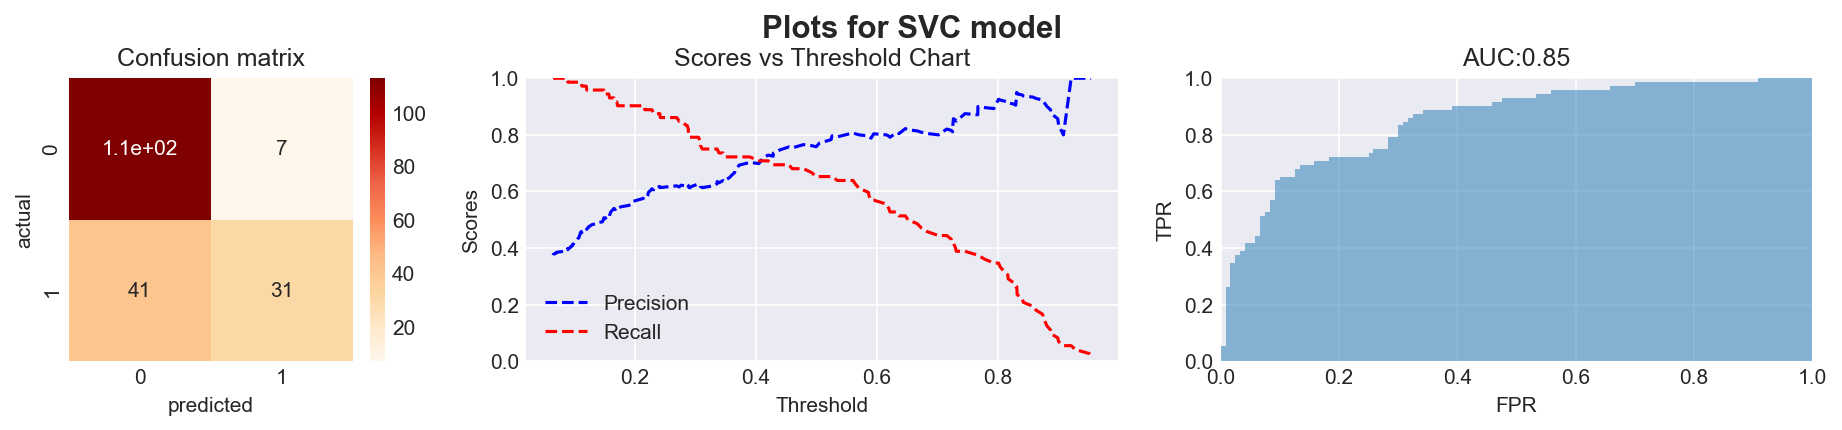

__________________________________________________________________________
GAUSSIAN NB model:

train accuracy:  0.7378472222222222
test accuracy:  0.7760416666666666
cross validation f1 score: 0.6358397104949326

classification report:
               precision    recall  f1-score   support

           0       0.81      0.84      0.82       120
           1       0.72      0.67      0.69        72

    accuracy                           0.78       192
   macro avg       0.76      0.75      0.76       192
weighted avg       0.77      0.78      0.77       192



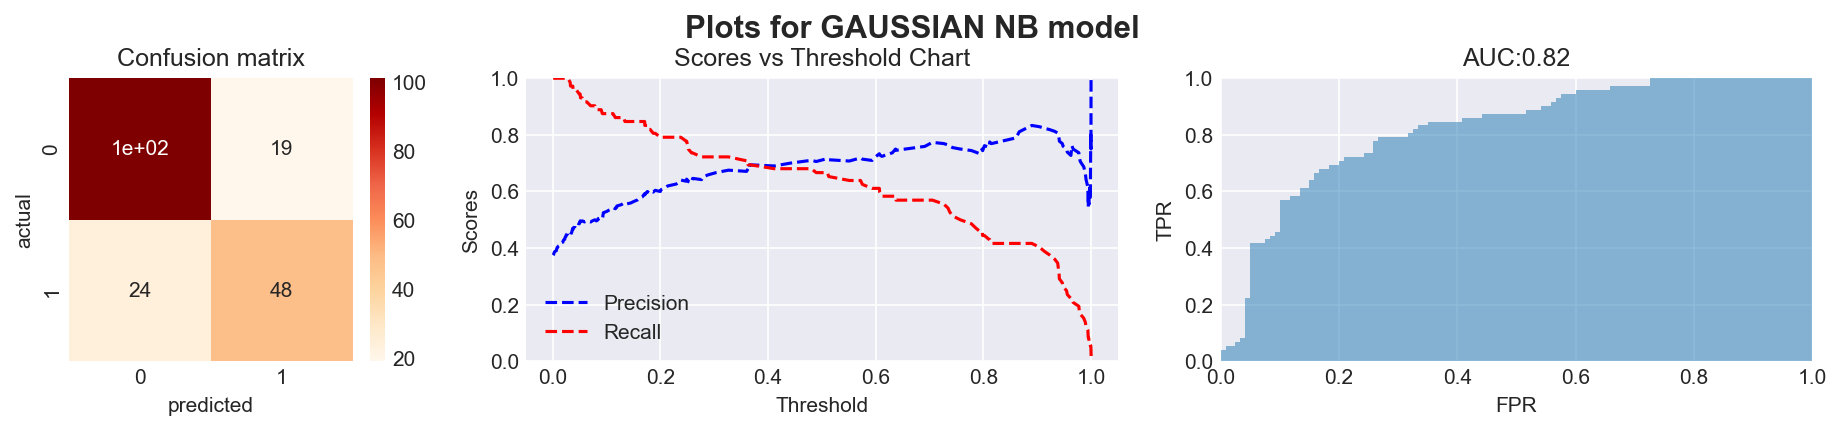

__________________________________________________________________________
KNC model:

train accuracy:  1.0
test accuracy:  0.7395833333333334
cross validation f1 score: 0.5647051145570499

classification report:
               precision    recall  f1-score   support

           0       0.76      0.86      0.80       120
           1       0.70      0.54      0.61        72

    accuracy                           0.74       192
   macro avg       0.73      0.70      0.71       192
weighted avg       0.73      0.74      0.73       192



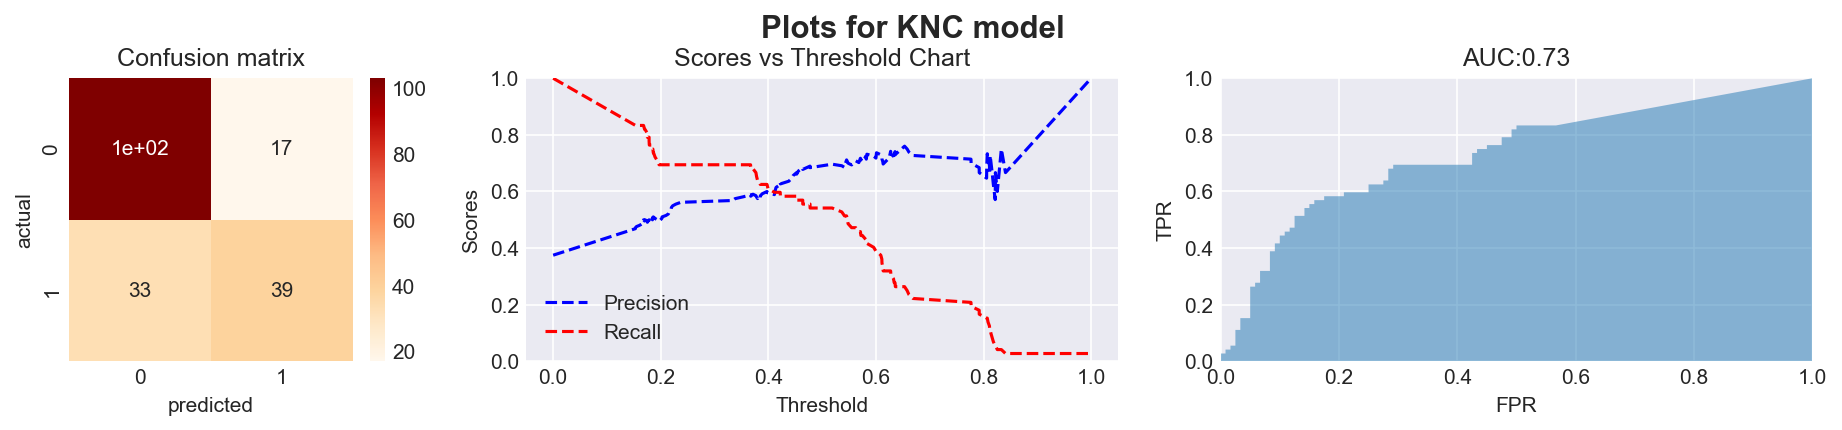

__________________________________________________________________________
RNC model:

train accuracy:  1.0
test accuracy:  0.625
cross validation f1 score: 0.0

classification report:
               precision    recall  f1-score   support

           0       0.62      1.00      0.77       120
           1       0.00      0.00      0.00        72

    accuracy                           0.62       192
   macro avg       0.31      0.50      0.38       192
weighted avg       0.39      0.62      0.48       192



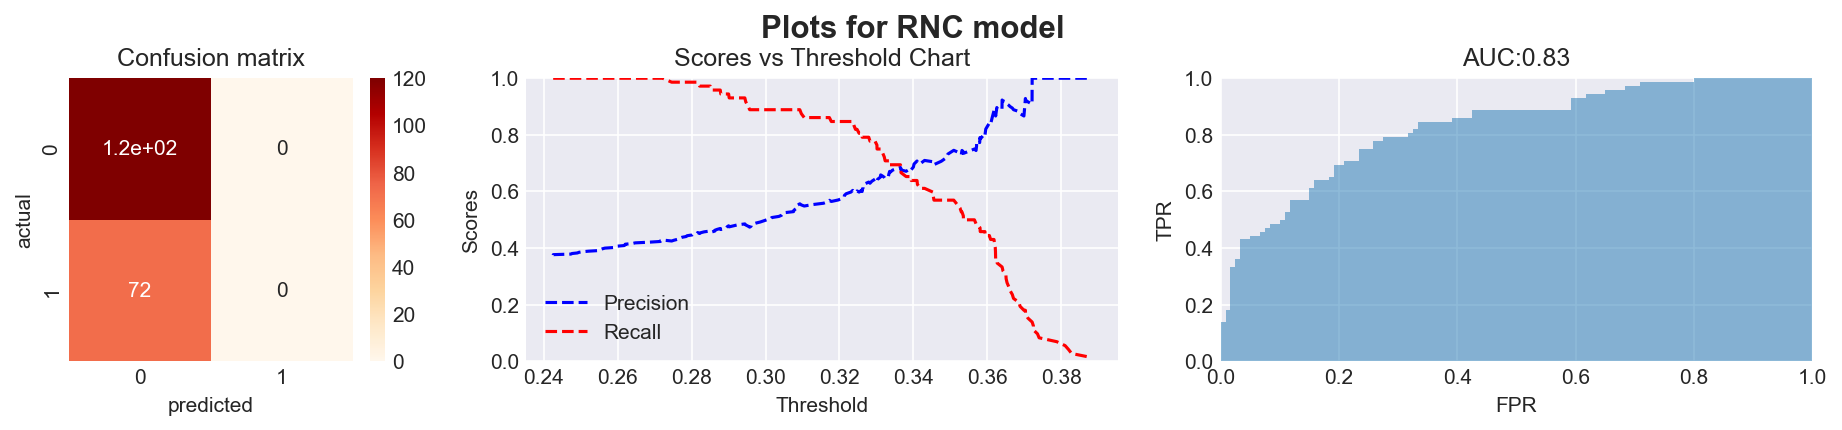

__________________________________________________________________________
XGBOOST model:

train accuracy:  1.0
test accuracy:  0.734375
cross validation f1 score: 0.6118696899894356

classification report:
               precision    recall  f1-score   support

           0       0.78      0.81      0.79       120
           1       0.66      0.61      0.63        72

    accuracy                           0.73       192
   macro avg       0.72      0.71      0.71       192
weighted avg       0.73      0.73      0.73       192



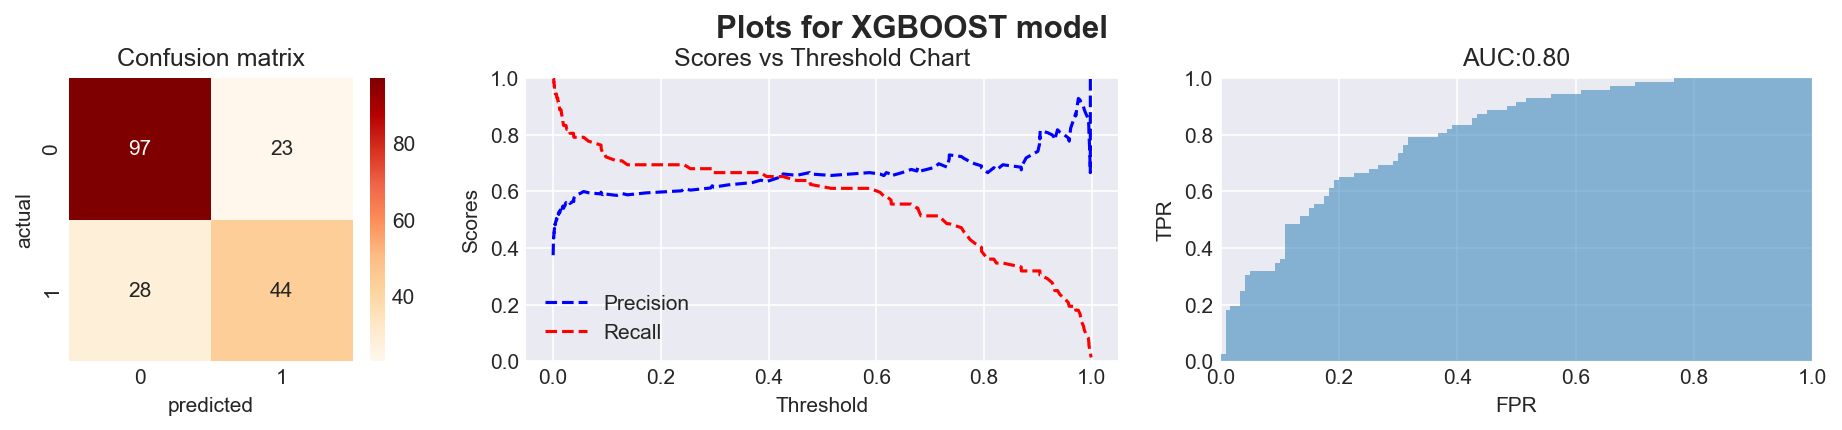

__________________________________________________________________________


In [21]:
pipelines=[]
f1={}

for name,model in models.items():
    
    # making pipeline for each model
    pipeline = Pipeline(steps=[( "preprocessor", MinMaxScaler() ),
                               ( "classifier", model )
                              ]
                       )
    
    # print name of pipeline
    print(name.upper(), 'model:\n')
    
    # fitting data
    pipeline.fit(xtrain,ytrain)
    
    # calculating scores and storing
    score_cv=np.mean( cross_val_score(pipeline, X, y, cv=5, scoring='f1', n_jobs=-1) )
    f1[name]=score_cv
    
    # printing scores
    print('train accuracy: ', pipeline.score(xtrain,ytrain) )
    print('test accuracy: ', pipeline.score(xtest,ytest) )
    print('cross validation f1 score:', score_cv)
    print('\nclassification report:\n', classification_report(ytest,pipeline.predict(xtest)) )
    


                                         ############### CALCULATIONS ##################
    
    '''scores vs threshold'''
    from sklearn.metrics import precision_recall_curve, auc, roc_curve, roc_auc_score
    
    # probs_y is a 2-D array of probability of being labeled as 0 (first column of  array) vs 1 (2nd column in array)
    y_probs=pipeline.predict_proba(xtest) 

    precision, recall, thresholds = precision_recall_curve(ytest, y_probs[:,1]) 

    #retrieve probability of being 1(in second column of probs_y)
    pr_auc = auc(recall, precision)
    
    '''AUC ROC'''
    y_pred_proba = pipeline.predict_proba(xtest)[::,1]
    fpr, tpr, _ = roc_curve(ytest,  y_pred_proba)
    auc = roc_auc_score(ytest, y_pred_proba)
    
    
                                        ################ PLOTTING ##################
    fig, (ax1, ax2, ax3)=plt.subplots(1,3, figsize=(15,2.5), dpi=150, gridspec_kw={'width_ratios': [6, 10, 10]} )  
    
    # confusion matrix
    sns.heatmap( confusion_matrix(ytest,pipeline.predict(xtest)), annot=True, cmap='OrRd', ax=ax1 )
    ax1.set_xlabel('predicted')
    ax1.set_ylabel('actual')
    ax1.set_title('Confusion matrix')
    
    # scores vs threshold
    ax2.plot(thresholds, precision[: -1], "b--", label="Precision")
    ax2.plot(thresholds, recall[: -1], "r--", label="Recall")
    ax2.set_ylabel("Scores")
    ax2.set_xlabel("Threshold")
    ax2.set_title("Scores vs Threshold Chart")
    ax2.legend(loc="lower left")
    ax2.set_ylim([0,1])
    
    # AUC ROC
    ax3.stackplot(fpr, tpr, alpha=0.5)
    ax3.set_title(f'AUC:{ auc :.2f}')
    ax3.set_xlabel('FPR')
    ax3.set_ylabel('TPR')
    ax3.set_xlim(0,1)
    ax3.set_ylim(0,1)
    
    plt.suptitle(f'Plots for {name.upper()} model', fontsize=15, y=1.05, fontweight='bold')
    plt.show()
    
    print('__________________________________________________________________________')
    

### storing f1 scores as a dataframe

In [22]:
df_f1=pd.DataFrame(f1.values(), index=f1.keys(), columns=['f1_score'])
df_f1

,f1_score
logistic,0.368792
decision tree,0.600890
random forest,0.621849
adaboost using dt,0.183563
adaboost using rf,0.644256
gradboost,0.622569
SVC,0.588588
Gaussian NB,0.635840
KNC,0.564705
RNC,0.000000


### model scores comparison

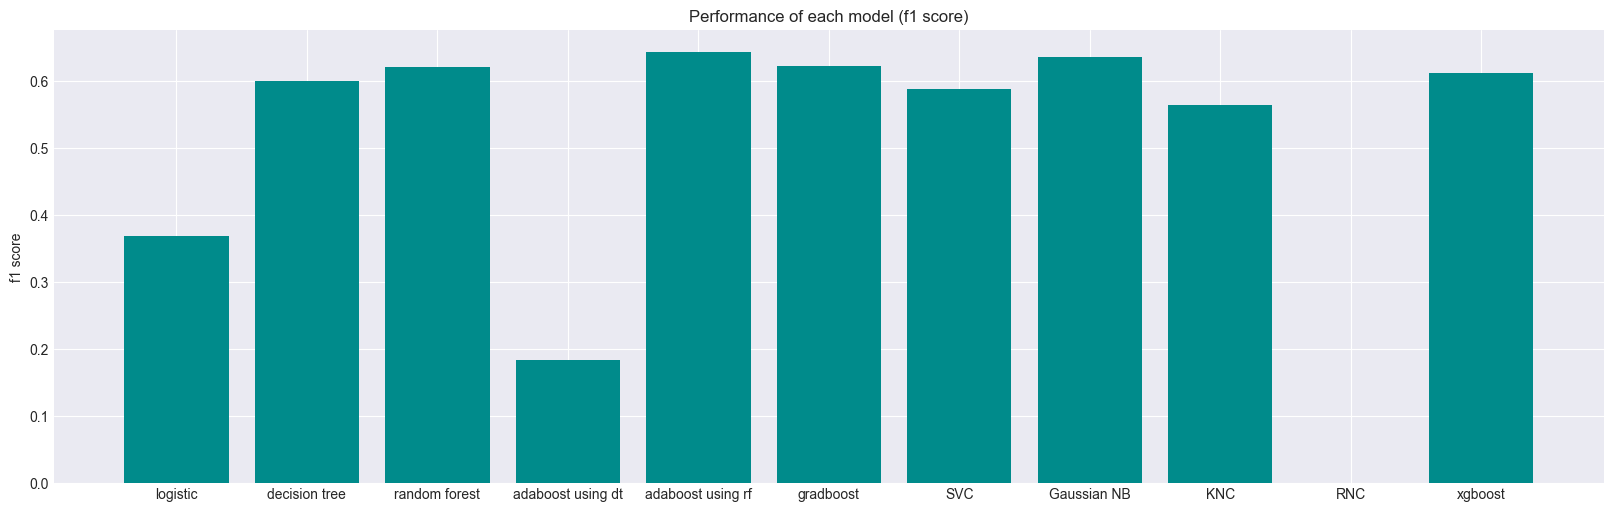

In [23]:
plt.figure(figsize=(20,6), dpi=100)
plt.bar( df_f1.index, df_f1.f1_score, color='darkcyan', )
plt.ylabel('f1 score')
plt.title('Performance of each model (f1 score)')
plt.show()

    most of the models seem to be predicting no diabetes easily
    whereas they are unable to predict diabetes happening
### ***This is mostly due to imbalanced classes and the lower occuring class needs to be balanced***

# Expt

In [24]:
# import gc
# gc.collect()